## **Bank Analytic: Potensial Nasabah Deposito**

Tujuan dari pembuatan machine learning ini adalah bank ingin meningkatkan jumlah nasabah yang akan melakukan deposito berjangka. Dalam hal ini bank menghubungi sebuah nasabah melalui telepon, email, atau kontak langsung untuk menawarkan produk deposito. Tapi sayangnya tidak semua orang yang dihubungi akhirnya membuka deposito berjangka. Di sini kita asumsikan rata-rata deposito nasabah Rp 10.000.000.

Target:
- 0: nasabah yang tidak buka deposito
- 1: nasabah yang akan buka deposito

**Pemasalahan**
<br>

Melakukan kontak ke nasabah melalui email, telepon atau kontak langsung untuk menawarkan produk deposit memakan biaya, waktu dan juga tenaga, untuk itu bank ingin menekan *budget campaign* dengan menargetkan *campaign* ke nasabah yang memang berpotensi dan berminat untuk membuka deposito jangka panjang.


Type 1 error : False Positive  
- Konsekuensi: sia-sianya biaya komunikasi (telepon atau email), waktu dan sumber daya
- Kerugian: Rp. 75.000 per orang

Type 2 error : False Negative  
- Konsekuensi: kehilangan calon potensial - kehilangan margin profit per deposito
- Kerugian: bunga bersih dari hasil pemutaran uang nasabah Rp 150.000/orang/bulan

Dengan kata lain, **kesalahan FN dua kali lebih mahal daripada FP.**

Berdasarkan konsekuensinya, maka sebisa mungkin yang akan kita lakukan adalah membuat model yang dapat memprediksi apakah seorang nasabah akan melakukan deposito berjangka. Model ini bertujuan membantu tim marketing agar promosi bisa lebih terarah, dan meminimalkan pemborosan biaya pada nasabah yang tidak tertarik.

Jadi nanti metric utama yang akan kita gunakan adalah **f2 score**, karena:
- Lebih **menekankan recall**, yaitu kemampuan model dalam menangkap sebanyak mungkin nasabah yang akan deposito.
- Sesuai dengan prioritas bisnis: **lebih baik menghubungi beberapa orang yang salah, daripada melewatkan orang yang benar-benar akan deposit**



## **Data Understanding and Cleaning**

Kolom pada data:
- age: Usia nasabah
- job: Jenis pekerjaan nasabah
- balance: Saldo rekening
- housing: Punya pinjaman rumah? (yes/no)
- loan:	Punya pinjaman pribadi? (yes/no)
- contact: Cara dikontak (cellular/telephone)
- month: Bulan terakhir dikontak
- campaign: Berapa kali dikontak selama kampanye sekarang
- pdays: Hari sejak kontak dari kampanye sebelumnya (-1 = belum pernah)
- poutcome:	Hasil kampanye sebelumnya (success/failure/unknown)
- deposit:	Target: buka deposito atau nggak (yes/no)

In [133]:
#!pip install xgboost lightgbm

In [134]:
# Library

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import confusion_matrix, recall_score, fbeta_score, make_scorer


# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

In [135]:
#Load Dataset
df = pd.read_csv("data_bank_marketing_campaign.csv")
df

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...
7808,62,housemaid,2,no,no,cellular,nov,1,-1,unknown,yes
7809,48,housemaid,5473,no,no,cellular,feb,2,184,success,yes
7810,36,unknown,179,no,no,cellular,aug,8,-1,unknown,no
7811,31,admin.,54,yes,no,cellular,nov,1,-1,unknown,no


In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813 entries, 0 to 7812
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       7813 non-null   int64 
 1   job       7813 non-null   object
 2   balance   7813 non-null   int64 
 3   housing   7813 non-null   object
 4   loan      7813 non-null   object
 5   contact   7813 non-null   object
 6   month     7813 non-null   object
 7   campaign  7813 non-null   int64 
 8   pdays     7813 non-null   int64 
 9   poutcome  7813 non-null   object
 10  deposit   7813 non-null   object
dtypes: int64(4), object(7)
memory usage: 671.6+ KB


In [137]:
df['deposit'].value_counts(normalize=True)

no     0.522335
yes    0.477665
Name: deposit, dtype: float64

Ini menunjukkan bahwa proporsi data kita hampir balance, dengan proporsi 52:48

In [138]:
#mengecek apakah ada missing value
df.isna().sum()

age         0
job         0
balance     0
housing     0
loan        0
contact     0
month       0
campaign    0
pdays       0
poutcome    0
deposit     0
dtype: int64

In [139]:
# mengecek apakah ada duplikasi
df.duplicated().sum()

8

In [140]:
#menghapus kolom duplikasi
df.drop_duplicates(inplace=True)

In [141]:
#mengubah kolom deposit menjadi 0 dan 1
df['deposit'] = df['deposit'].map({'no': 0, 'yes': 1})

In [142]:
pd.set_option('display.max_colwidth', None)
# data uni di tiap kolom
listItem = []
for col in df.columns :
    listItem.append( [col, df[col].nunique(), df[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Sample
0,age,75,"[55, 39, 51, 38, 36, 41, 37, 35, 57, 23, 33, 31, 53, 30, 46, 48, 25, 29, 28, 52, 49, 44, 42, 27, 47, 64, 26, 34, 56, 32, 58, 45, 54, 50, 79, 65, 40, 24, 60, 43, 61, 59, 62, 68, 82, 71, 73, 76, 69, 20, 72, 22, 67, 19, 70, 75, 63, 93, 77, 80, 66, 21, 87, 81, 92, 88, 84, 83, 78, 74, 18, 85, 95, 86, 90]"
1,job,12,"[admin., self-employed, services, housemaid, technician, management, student, blue-collar, entrepreneur, retired, unemployed, unknown]"
2,balance,3153,"[1662, -3058, 3025, -87, 205, -76, 4803, 911, 805, 0, 1234, 1107, 1170, 341, 4808, 88, 169, 863, 242, 2597, 4929, 277, 1438, 15, 3733, 204, 1684, 1025, 55, 19, 348, 785, 742, 511, 6651, 1612, 555, 54, 1185, 110, 950, 412, 228, 367, 3993, 2599, 3528, 32, 551, 3161, 533, 8725, 349, 514, 2688, -194, 154, 874, 2, 5953, 1269, -327, 235, 7, 2661, 1948, 20, 502, 193, 13658, 1716, 172, 1667, 157, 8, 951, 427, 241, 469, 2060, 7177, 655, -114, 588, -971, 4570, 250, 131, 93, 22, 15341, 356, 190, -124, 2228, -60, 376, 1567, 855, 4151, ...]"
3,housing,2,"[no, yes]"
4,loan,2,"[no, yes]"
5,contact,3,"[cellular, telephone, unknown]"
6,month,12,"[jun, apr, may, nov, jan, sep, feb, mar, aug, jul, oct, dec]"
7,campaign,32,"[2, 3, 1, 4, 5, 6, 7, 30, 8, 9, 11, 14, 10, 28, 63, 12, 24, 17, 15, 18, 19, 13, 21, 23, 22, 33, 16, 25, 26, 20, 29, 43]"
8,pdays,422,"[-1, 352, 21, 91, 186, 263, 96, 355, 294, 412, 89, 114, 276, 93, 175, 57, 323, 156, 86, 95, 271, 182, 289, 334, 269, 309, 144, 183, 417, 138, 254, 337, 171, 389, 87, 170, 165, 372, 247, 98, 196, 469, 272, 104, 63, 587, 336, 145, 130, 28, 202, 324, 147, 94, 328, 420, 179, 90, 81, 160, 298, 356, 357, 267, 430, 52, 181, 365, 237, 330, 103, 374, 75, 133, 321, 204, 782, 266, 197, 270, 318, 349, 187, 359, 490, 192, 227, 100, 168, 177, 251, 301, 350, 92, 184, 345, 290, 199, 333, 169, ...]"
9,poutcome,4,"[unknown, other, failure, success]"


In [143]:
for col in ['job', 'contact', 'poutcome']:
    print(f"{col} unknown count: {df[df[col]=='unknown'].shape[0]}")

job unknown count: 54
contact unknown count: 1636
poutcome unknown count: 5811


Bisa kita lihat terdapat data unknown di kolom job, contact dan poutcome. Di sini kita akan memperlakukan data unknown sebagai kategori lain dikarenakan jumlahnya cukup banyak terutama di kolom contact dan poutcome dan dalam dunia marketing, unknown bisa juga berarti nasabah belum pernah dihubungi di campaign sebelumnya.

Dalam data juga terdapat nilai pdays -1 yang artinya belum pernah dihubungi semenjak *campaign* sebelumnya yang kemungkinannya nasabah ini merupakan nasabah baru. 

In [144]:
#menampilkan kolom yang pdays < 0
df_pdays = df[df['pdays'] < 0]
df_pdays

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,1
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,1
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,0
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,0
5,41,admin.,-76,yes,no,cellular,apr,1,-1,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...
7807,33,management,0,yes,yes,cellular,may,2,-1,unknown,0
7808,62,housemaid,2,no,no,cellular,nov,1,-1,unknown,1
7810,36,unknown,179,no,no,cellular,aug,8,-1,unknown,0
7811,31,admin.,54,yes,no,cellular,nov,1,-1,unknown,0


In [145]:
df_pdays['poutcome'].value_counts()

unknown    5809
Name: poutcome, dtype: int64

5809 nasabah atau 74,34% belum pernah dihubungi dari total data 7813, dan dengan hasil poutcome yang unknown menjelaskan bahwa nasabah benar-benar baru.

In [146]:
df_pdays['deposit'].value_counts()

0    3438
1    2371
Name: deposit, dtype: int64

Dari 5809 nasabah yang belum pernah dihubungi sebelumnya (pdays = -1), sebanyak 41% tetap membuka deposito.

Hal ini menunjukkan bahwa tidak semua keberhasilan kampanye pemasaran bergantung pada kontak sebelumnya.
Beberapa nasabah mungkin sudah memiliki niat atau kebutuhan untuk membuka deposito tanpa perlu dipengaruhi oleh kampanye langsung.

Selain itu, ini mengindikasikan bahwa:
- Channel marketing pasif (misal: brosur di cabang, website, promosi lewat teller) bisa berkontribusi terhadap keputusan nasabah
- Nasabah bisa saja berada pada momentum finansial tertentu (misalnya baru menerima bonus, THR, atau hasil bisnis) sehingga lebih siap membuka deposito, walau belum pernah dihubungi

Dalam kolom balance juga bisa kita lihat bahwa ada nilai negatif. Yang artinya saldo nasabah minus.

In [147]:
df_neg = df[df['balance'] < 0]
print(f"Jumlah nasabah dengan saldo negatif: {len(df_neg)}")
print(f"Persentase dari total: {len(df_neg)/len(df)*100:.2f}%")

Jumlah nasabah dengan saldo negatif: 479
Persentase dari total: 6.14%


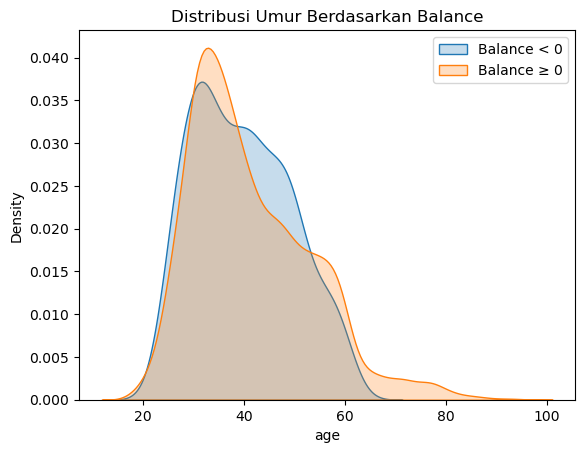

In [148]:
sns.kdeplot(df[df['balance'] < 0]['age'], label='Balance < 0', shade=True)
sns.kdeplot(df[df['balance'] >= 0]['age'], label='Balance ≥ 0', shade=True)
plt.title('Distribusi Umur Berdasarkan Balance')
plt.legend()
plt.show()

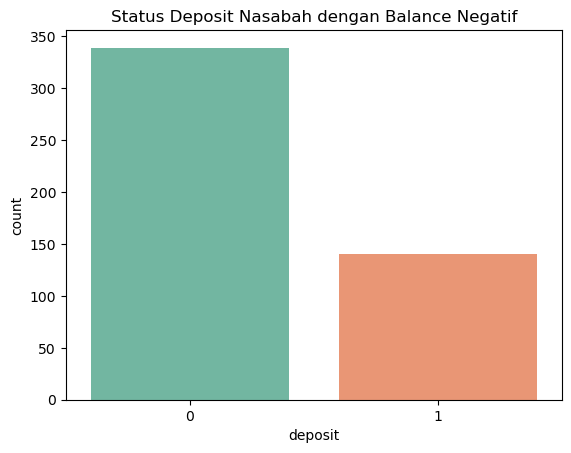

In [149]:
sns.countplot(data=df_neg, x='deposit', palette='Set2')
plt.title('Status Deposit Nasabah dengan Balance Negatif')
plt.show()

In [150]:
df['negative_balance'] = df['balance'] < 0

pd.crosstab(df['negative_balance'], df['loan'], normalize='index') * 100

loan,no,yes
negative_balance,,
False,88.124488,11.875512
True,67.849687,32.150313


Sebanyak 32.15% dari nasabah yang memiliki saldo negatif juga memiliki pinjaman (loan = yes), dibandingkan hanya 11.86% pada nasabah yang saldo-nya positif.

In [151]:
df['negative_balance'] = df['balance'] < 0

pd.crosstab(df['negative_balance'], df['housing'], normalize='index') * 100

housing,no,yes
negative_balance,,
False,54.804805,45.195195
True,25.260960,74.739040


Sebanyak 74.74%% dari nasabah yang memiliki saldo negatif memiliki rumah, nilainya lebih tinggi jika dibandingkan dengan kepimilikan rumah dari nasabah yang saldonya positif.

In [152]:
df['negative_balance'] = df['balance'] < 0

pd.crosstab(df['negative_balance'], df['deposit'], normalize='index') * 100

deposit,0,1
negative_balance,,
False,50.996451,49.003549
True,70.772443,29.227557


Hanya 29% nasabah yang memiliki saldo negatif mempunyai deposito berjangka.

Di sini saya menemukan bahwa 479 nasabah atau sekitar 6.14% dari total data memiliki saldo negatif. Meskipun jumlahnya tidak besar secara keseluruhan, kelompok ini memperlihatkan pola perilaku yang sangat berbeda dibandingkan nasabah lainnya — dan layak untuk diperhatikan secara khusus.

Salah satu hal yang menonjol adalah tingginya persentase nasabah dengan pinjaman (loan = yes) di kelompok ini, yaitu sebesar 32.15%, dibandingkan hanya 11.86% pada nasabah dengan saldo positif. Artinya, nasabah dengan saldo negatif cenderung memiliki beban finansial tambahan, seperti pinjaman konsumtif atau cicilan lainnya.

Menariknya, sebanyak 74.74% dari nasabah dengan saldo negatif ternyata memiliki rumah. Persentase ini jauh lebih tinggi dibandingkan nasabah dengan saldo positif. Hal ini mengindikasikan bahwa meskipun mereka memiliki aset, mereka mungkin sedang dalam kondisi keuangan yang “ketat”, misalnya karena cicilan rumah bulanan yang menyita sebagian besar penghasilan mereka.

Hal ini juga tercermin dari minat mereka terhadap produk deposito berjangka. Hanya 29.23% nasabah dengan saldo negatif yang membuka deposito, sedangkan pada nasabah dengan saldo positif, angkanya mencapai 49%.

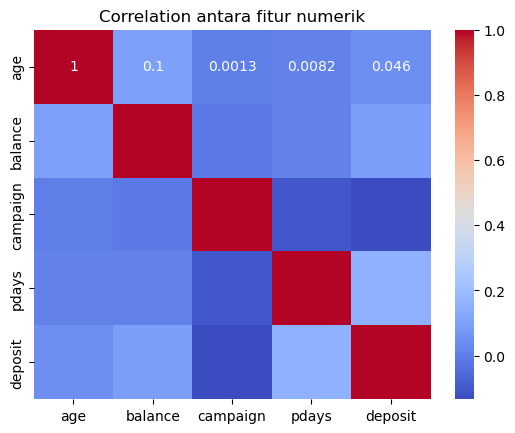

In [153]:
#Korelasi antar kolom numerik
num_cols = ['age', 'balance', 'campaign', 'pdays', 'deposit']
corr = df[num_cols].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation antara fitur numerik")
plt.show()

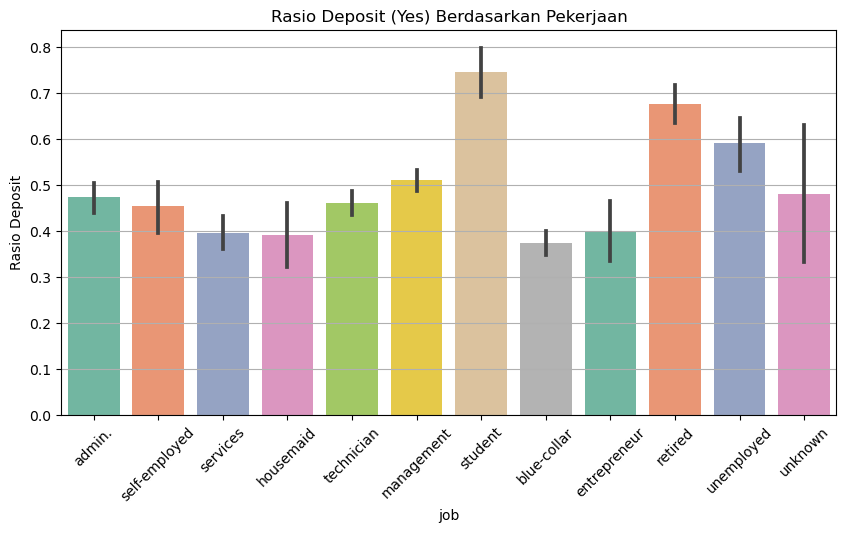

In [154]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='job', y='deposit', estimator=np.mean, palette='Set2')
plt.title('Rasio Deposit (Yes) Berdasarkan Pekerjaan')
plt.ylabel('Rasio Deposit')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [155]:
job_deposit_crosstab = pd.crosstab(df['job'], df['deposit'], normalize='index') * 100
job_deposit_crosstab.columns = ['Tidak Buka Deposit', 'Buka Deposit']
job_deposit_crosstab = job_deposit_crosstab.sort_values(by='Buka Deposit', ascending=False)

job_deposit_crosstab


,Tidak Buka Deposit,Buka Deposit
job,,
student,25.506073,74.493927
retired,32.407407,67.592593
unemployed,40.963855,59.036145
management,48.965903,51.034097
unknown,51.851852,48.148148
admin.,52.564103,47.435897
technician,53.840186,46.159814
self-employed,54.642857,45.357143
entrepreneur,60.169492,39.830508


Kelompok dengan rasio pembukaan deposito tertinggi adalah “student” dan “retired”, masing-masing mencapai sekitar 74% dan 68%.

Pekerjaan seperti “blue-collar,” “housemaid,” “services,” dan “entrepreneur” menunjukkan tingkat pembukaan deposito yang lebih rendah, berkisar antara 37% hingga 40%. 

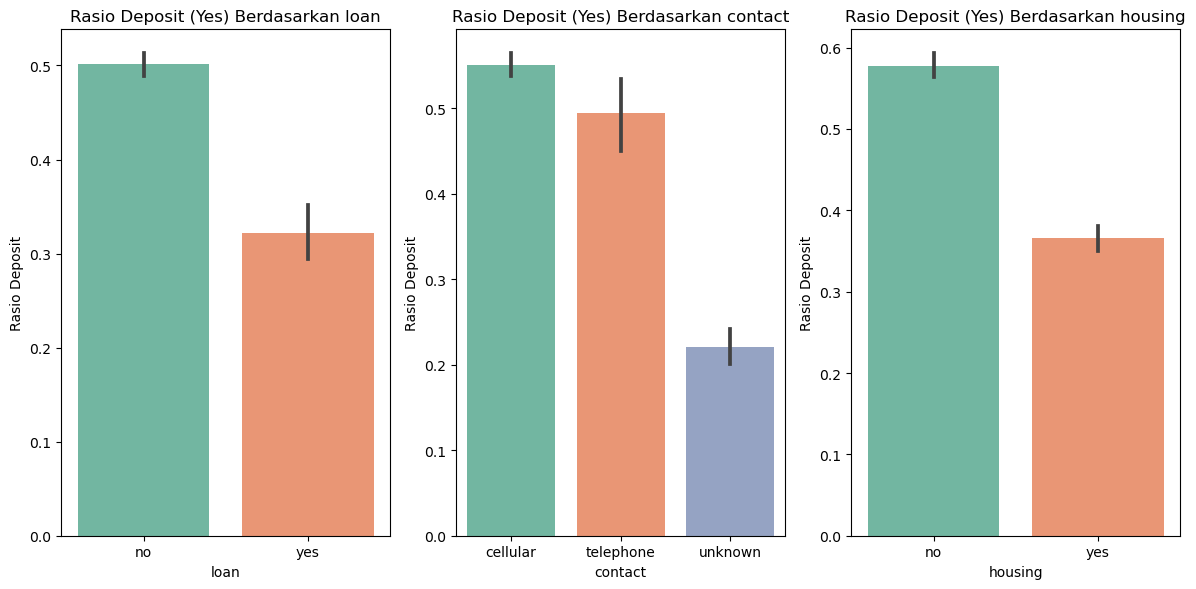


Cross Tab: loan
      Tidak Buka Deposit  Buka Deposit
loan                                  
no             49.859903     50.140097
yes            67.773438     32.226562

Cross Tab: contact
           Tidak Buka Deposit  Buka Deposit
contact                                    
cellular            44.887071     55.112929
telephone           50.549451     49.450549
unknown             77.933985     22.066015

Cross Tab: housing
         Tidak Buka Deposit  Buka Deposit
housing                                  
no                42.263056     57.736944
yes               63.423276     36.576724


In [156]:
cat_col = ['loan', 'contact', 'housing']

plt.figure(figsize=(12, 6))

for i, col in enumerate(cat_col, 1):
    plt.subplot(1, 3, i)
    sns.barplot(data=df, x=col, y='deposit', estimator=np.mean, palette='Set2')
    plt.title(f'Rasio Deposit (Yes) Berdasarkan {col}')
    plt.ylabel('Rasio Deposit')
    plt.tight_layout()

plt.show()

for col in cat_col:
    print(f'\nCross Tab: {col}')
    ct = pd.crosstab(df[col], df['deposit'], normalize='index') * 100
    ct.columns = ['Tidak Buka Deposit', 'Buka Deposit']
    print(ct.sort_values(by='Buka Deposit', ascending=False))

Nasabah yang tidak memiliki pinjaman cenderung lebih tertarik membuka deposito, dengan rasio pembukaan mencapai 50.14%.
Sebaliknya, nasabah yang memiliki pinjaman hanya 32.23% yang membuka deposito.

Nasabah yang dihubungi melalui “cellular” menunjukkan konversi tertinggi (55.11%), diikuti oleh “telephone” (49.45%).

Nasabah yang tidak memiliki rumah justru memiliki rasio pembukaan deposito yang lebih tinggi (57.74%) dibandingkan yang memiliki rumah (36.58%).

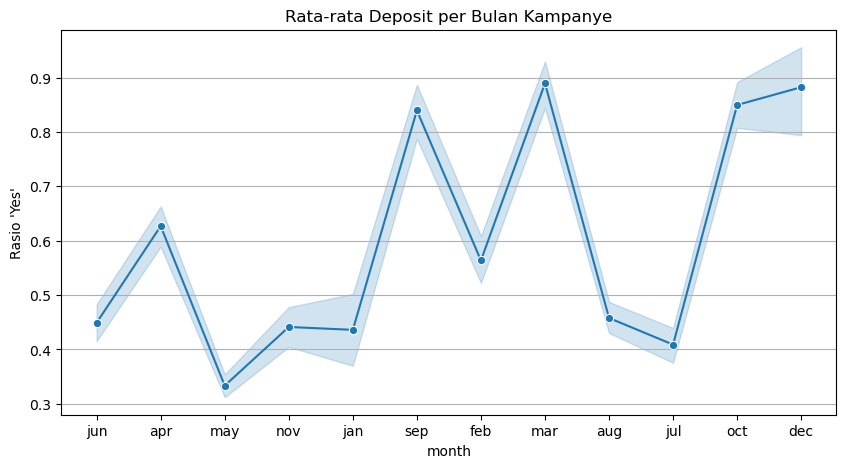

In [157]:
plt.figure(figsize=(10,5))
sns.lineplot(x='month', y='deposit', data=df, estimator=np.mean, marker='o', palette='Set2')
plt.title("Rata-rata Deposit per Bulan Kampanye")
plt.ylabel("Rasio 'Yes'")
plt.grid(axis='y')
plt.show()

In [158]:
deposit_per_month = df.groupby('month')['deposit'].mean().reset_index()
deposit_per_month['deposit'] = deposit_per_month['deposit'] * 100 
print(deposit_per_month)

   month    deposit
0    apr  62.688822
1    aug  45.790934
2    dec  88.235294
3    feb  56.367041
4    jan  43.612335
5    jul  40.896092
6    jun  44.924154
7    mar  88.944724
8    may  33.350228
9    nov  44.140030
10   oct  84.965035
11   sep  83.962264


- Bulan dengan rasio pembukaan deposito tertinggi adalah Maret (88.94%), Desember (88.24%), dan Oktober (84.97%), yang menunjukkan efektivitas kampanye yang sangat baik di periode-periode tersebut.
- Bulan-bulan lain dengan tingkat pembukaan deposito yang tinggi adalah September (83.96%) dan April (62.69%), yang juga menunjukkan potensi kuat bagi kampanye pemasaran.
- Bulan dengan rasio pembukaan deposito yang relatif rendah, seperti Mei (33.35%), Juli (40.90%), dan Januari (43.61%). Ini bisa menjadi indikasi bahwa faktor musiman atau kondisi ekonomi tertentu mempengaruhi keputusan nasabah dalam membuka deposito.
- Bulan-bulan seperti Agustus (45.79%), Juni (44.92%), dan November (44.14%) juga menunjukkan performa yang moderat.

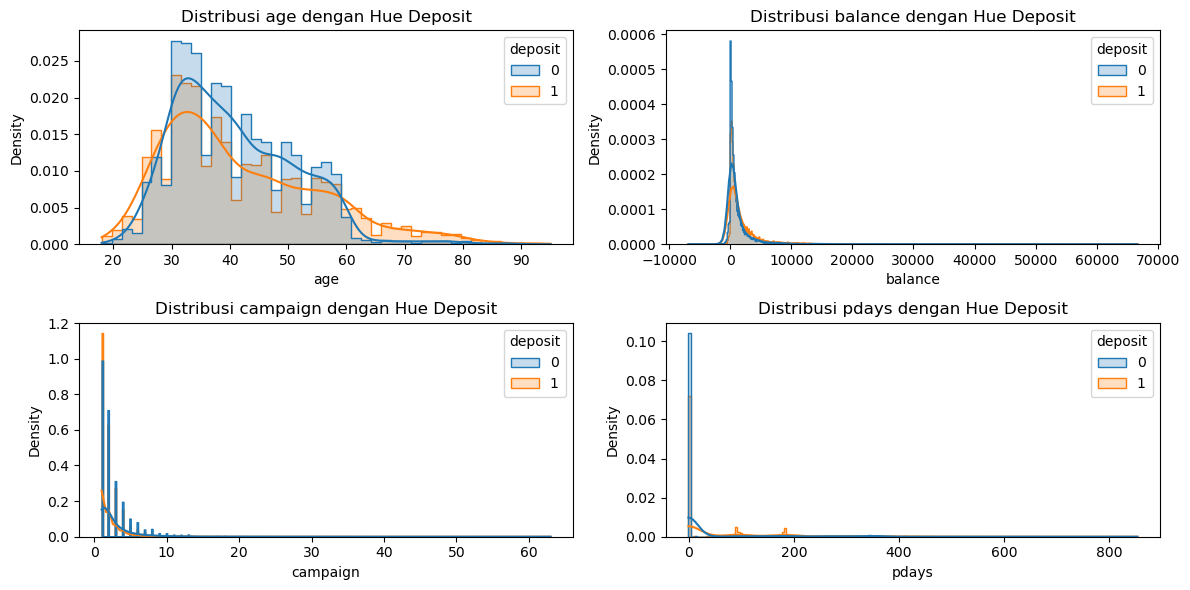

In [159]:
numeric_cols = ['age', 'balance', 'campaign', 'pdays']

plt.figure(figsize=(12, 6))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=df, x=col, hue='deposit', kde=True, element='step', stat='density')
    plt.title(f'Distribusi {col} dengan Hue Deposit')
    plt.tight_layout()

plt.show()

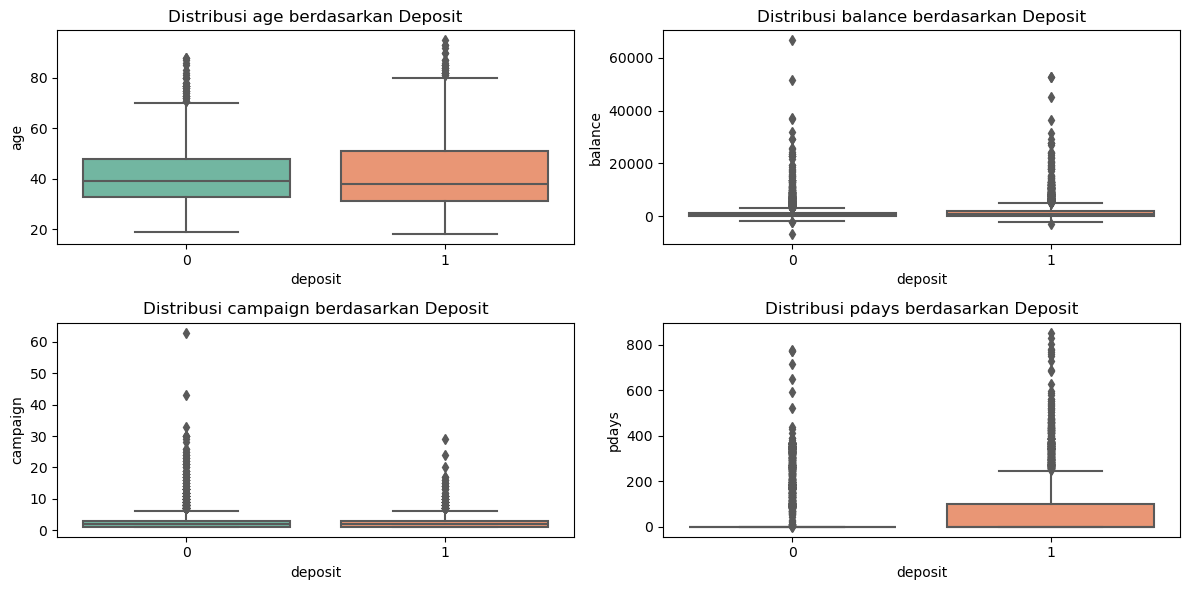

In [160]:
plt.figure(figsize=(12, 6))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, x='deposit', y=col, palette='Set2')
    plt.title(f'Distribusi {col} berdasarkan Deposit')
    plt.tight_layout()

plt.show()

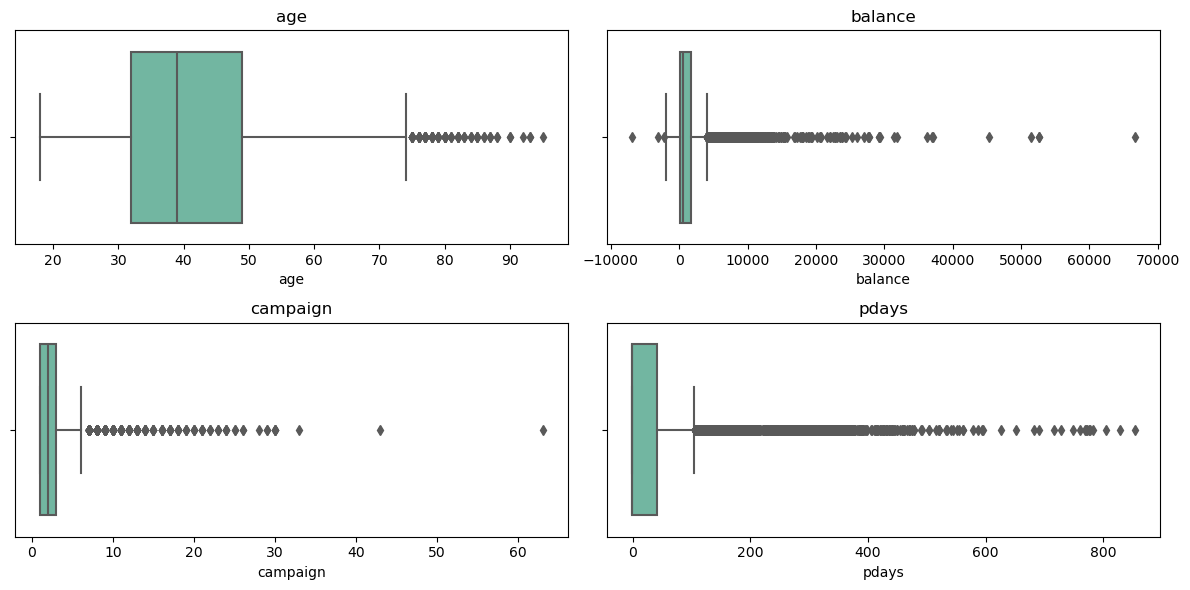

In [161]:
#cek outlier di kolom numerik

plt.figure(figsize=(12,6))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[col], palette='Set2')
    plt.title(col)
    plt.tight_layout()

plt.show()

In [162]:
# mencari nilai lower dan upper fence pada masing-masing kolom
list_lower = []
list_upper = []
number_lower = []
number_inside = []
number_upper = []
percent_outlier = []

n_total = len(df)  # total rows

for feature in numeric_cols: 
    IQR = df[feature].quantile(0.75) - df[feature].quantile(0.25)
    lower_fence = df[feature].quantile(0.25) - 1.5*IQR
    upper_fence = df[feature].quantile(0.75) + 1.5*IQR
    
    n_lower = len(df[df[feature] < lower_fence])
    n_inside = len(df[(df[feature] >= lower_fence) & (df[feature] <= upper_fence)])
    n_upper = len(df[df[feature] > upper_fence])
    
    # simpan nilai
    list_lower.append(lower_fence)
    list_upper.append(upper_fence)
    number_lower.append(n_lower)
    number_inside.append(n_inside)
    number_upper.append(n_upper)
    
    percent = ((n_lower + n_upper) / n_total) * 100
    percent_outlier.append(round(percent, 2))

# buat dataframe
outliers = pd.DataFrame({
    'Kolom' : numeric_cols,
    'Lower' : list_lower,
    'Upper' : list_upper,
    '# Lower' : number_lower,
    '# Inside' : number_inside,
    '# Upper' : number_upper,
    '% Outlier': percent_outlier
})

outliers


,Kolom,Lower,Upper,# Lower,# Inside,# Upper,% Outlier
0,age,6.5,74.5,0,7684,121,1.55
1,balance,-2207.5,4020.5,3,7069,733,9.43
2,campaign,-2.0,6.0,0,7376,429,5.50
3,pdays,-64.0,104.0,0,6373,1432,18.35


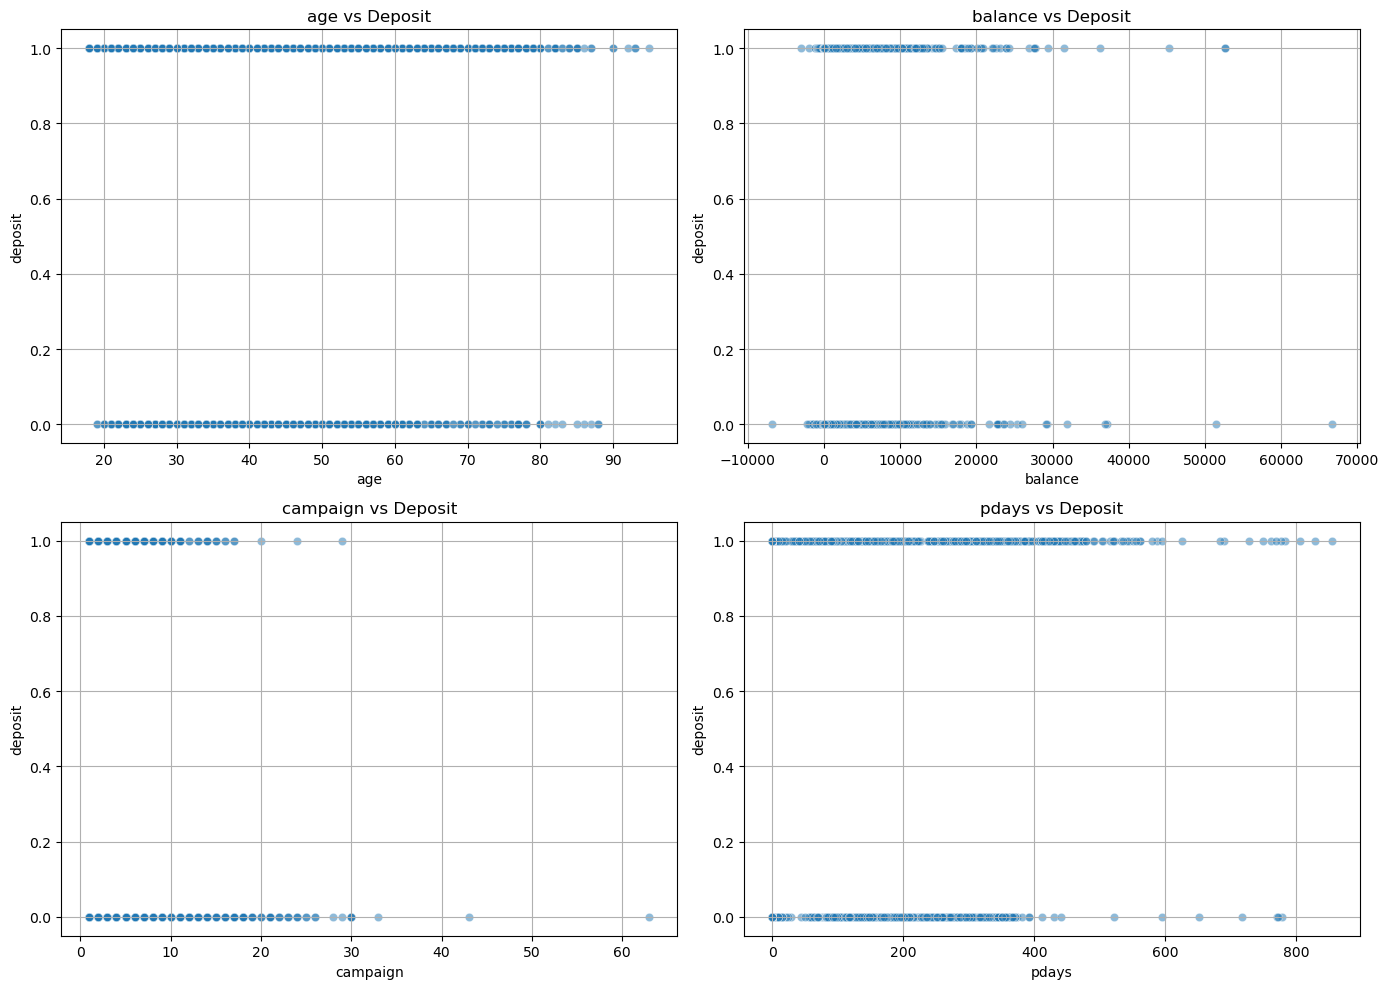

In [163]:
plt.figure(figsize=(14, 10))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(data=df, x=col, y='deposit', alpha=0.5, palette='Set2')
    plt.title(f'{col} vs Deposit')
    plt.grid(True)

plt.tight_layout()
plt.show()

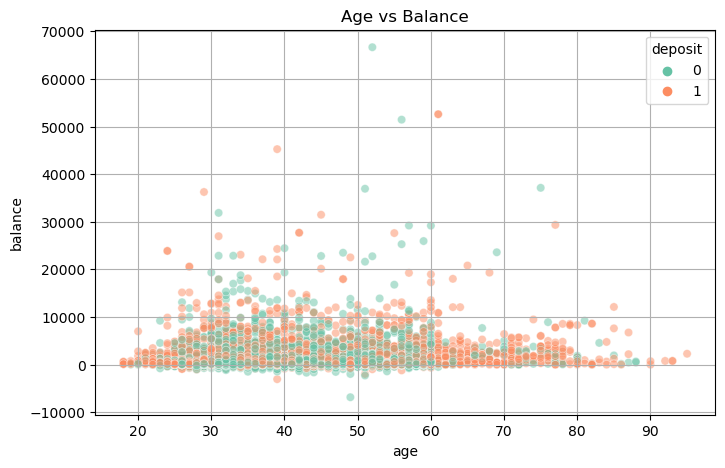

In [164]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='age', y='balance', hue='deposit', alpha=0.5, palette='Set2')
plt.title("Age vs Balance")
plt.grid(True)
plt.show()

In [165]:
pd.crosstab(df['pdays'], df['deposit'], normalize='index') * 100

deposit,0,1
pdays,,
-1,59.184025,40.815975
1,33.333333,66.666667
2,75.000000,25.000000
4,0.000000,100.000000
5,100.000000,0.000000
...,...,...
778,100.000000,0.000000
782,0.000000,100.000000
805,0.000000,100.000000


In [166]:
pd.crosstab(df['age'], df['deposit'], normalize='index') * 100

deposit,0,1
age,,
18,0.000000,100.000000
19,18.181818,81.818182
20,28.571429,71.428571
21,23.809524,76.190476
22,18.750000,81.250000
...,...,...
88,100.000000,0.000000
90,0.000000,100.000000
92,0.000000,100.000000


In [167]:
pd.crosstab(df['balance'], df['deposit'], normalize='index') * 100

deposit,0,1
balance,,
-6847,100.0,0.0
-3058,0.0,100.0
-2282,100.0,0.0
-1965,100.0,0.0
-1944,0.0,100.0
...,...,...
37127,100.0,0.0
45248,0.0,100.0
51439,100.0,0.0


In [168]:
pd.crosstab(df['campaign'], df['deposit'], normalize='index') * 100

deposit,0,1
campaign,,
1,46.374217,53.625783
2,53.089354,46.910646
3,53.311618,46.688382
4,56.204380,43.795620
5,62.500000,37.500000
6,65.306122,34.693878
7,62.135922,37.864078
8,77.528090,22.471910
9,68.085106,31.914894


In [169]:
df.groupby('pdays')['deposit'].value_counts(normalize=True).unstack().fillna(0).round(2).head(10)
df['pdays'].value_counts().head(20)

-1      5809
 92       80
 91       62
 182      61
 181      56
 183      54
 184      37
 93       29
 90       26
 98       26
 95       25
 94       25
 185      22
 87       21
 187      21
 97       19
 96       19
 189      18
 196      16
 342      16
Name: pdays, dtype: int64

In [170]:
df.groupby('age')['deposit'].value_counts(normalize=True).unstack().fillna(0).round(2).head(10)
df['age'].value_counts().sort_index().tail(20)

73    19
74    10
75    15
76    14
77    23
78    14
79     7
80    14
81     3
82     7
83     3
84     3
85     5
86     2
87     3
88     2
90     2
92     1
93     2
95     1
Name: age, dtype: int64

In [171]:
df.groupby('balance')['deposit'].value_counts(normalize=True).unstack().fillna(0).round(2).head(10)
df['balance'].value_counts().sort_index().tail(20)

23878    2
24277    1
24450    1
25290    1
25947    1
26965    1
27624    1
27696    2
29184    1
29207    1
29340    1
31472    1
31868    1
36252    1
36935    1
37127    1
45248    1
51439    1
52587    2
66653    1
Name: balance, dtype: int64

In [172]:
df.groupby('campaign')['deposit'].value_counts(normalize=True).unstack().fillna(0).round(2).head(10)
df['campaign'].value_counts().sort_index().tail(20)

13    23
14    10
15     8
16     7
17     9
18     7
19     4
20     4
21     5
22     3
23     3
24     4
25     2
26     2
28     1
29     2
30     4
33     1
43     1
63     1
Name: campaign, dtype: int64

In [173]:
def remove_outliers_iqr(df, cols):
    df_clean = df.copy()
    for col in cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

df_tanpa_outlier = remove_outliers_iqr(df, numeric_cols)

In [174]:
# Persentase data yang terhapus
persen_terhapus = ((len(df) - len(df_tanpa_outlier)) / len(df)) * 100

print(f"Total data awal: {len(df)}")
print(f"Total data setelah trim: {len(df_tanpa_outlier)}")
print(f"Banyak data terhapus: {(len(df) - len(df_tanpa_outlier))}")
print(f"Persentase data terhapus: {persen_terhapus:.2f}%")

Total data awal: 7805
Total data setelah trim: 5548
Banyak data terhapus: 2257
Persentase data terhapus: 28.92%


Berdasarkan informasi di atas, memang terdapat outlier pada kolom 'age', 'balance', 'campaign', dan 'pdays' tapi di sini tidak langsung kita hapus karena:
- Apabila kita menghapus outlier, kita akan kehilangan 28.92% data dimana ini akan memberikan pengaruh yang besar ke model kita.
- Dalam kolom Age, nasabah dengan umur > 80 tahun dinyatakan outlier akan tetapi secara pengetahuan bisnis, nasabah yang berusia lebih tua cenderung memiliki uang yang bisa dijadikan deposito sehingga nasabah yang berusia > 80 tahun penting untuk model training kita, karena jika sekarang kita hapus nasabah yang berusia > 80 tahun dan nantinya saat kita mempunyai nasabah yg berumur > 80 tahun, maka model kita akan langsung menyatakan bahwa nasabah tersebut tidak akan deposit.

Sehingga outlier di data kita akan ditangani berbeda yaitu dengan membuat pengelompokkan untuk kolom 'age', 'balance', 'campaign', dan 'pdays' seperti di bawah:
- Untuk kolom 'age' saya membuat kolom baru bernama 'age_group' untuk mengelompokkan usia pelanggan berdasarkan 3 kategori yaitu young, adult, dan senior sehingga nantinya model mengenali pola dalam kelompok umur
- Untuk kolom 'balance', saya juga membuat kolom baru bernama 'balance_group', untuk mengelompokkan balance dari nasabah dan juga saya menambahkan kolom 'negative_balance' untuk mengetahui apakah nasabah tersebut memiliki balance negatif atau tidak
- Untuk kolom 'campaign' saya juga membuat kolom baru bernama 'campaign_group' untuk mengetahui berapa kali nasabah dihubungi setelah campaign terakhir
- Untuk kolom 'pdays' saya membuat kolom baru bernama 'pdays_group' dan 'previous_contacted' untuk mengetahui apakah nasabah sudah pernah dihubungi atau belum. Pada kolom 'pdays', saya juga mengubah nilai -1 menjadi 0 agar mudah dibaca oleh machine learning dan juga agar mudah diolah.

Dengan pengelompokkan seperti ini, modal bisa membaca pola lebih stabil walaupun kita mempertahankan outlier dan nantinya model tidak terganggu oleh nilai ekstrim (outlier).

In [175]:
def age_group(x):
    if x < 30:
        return 'young'
    elif x < 60:
        return 'adult'
    else:
        return 'senior'

df['age_group'] = df['age'].apply(age_group)

In [176]:
df['balance_group'] = pd.cut(df['balance'],
    bins=[-8000, 0, 2000, 8000, 15000, df['balance'].max()],
    labels=['negatif', 'rendah', 'sedang', 'tinggi', 'sangat_tinggi'])

In [177]:
def campaign_bin(x):
    if x == 1:
        return 'one_time'
    elif x <= 3:
        return 'few_times'
    elif x <= 6:
        return 'moderate'
    else:
        return 'excessive'

df['campaign_group'] = df['campaign'].apply(campaign_bin)

In [178]:
def pdays_group(x):
    if x == -1:
        return 'never'
    elif x <= 30:
        return 'recent'
    elif x <= 180:
        return 'mid_term'
    else:
        return 'long_term'

df['pdays_group'] = df['pdays'].apply(pdays_group)
df['previous_contacted'] = df['pdays'].apply(lambda x: 0 if x == -1 else 1)

In [179]:
# Konversi kolom yes/no ke 1/0

binary_cols = ['housing', 'loan', 'negative_balance']

for col in binary_cols:
    df[col] = df[col].map({'yes': 1, 'no': 0})

#mengubah kolom negative_balance menjadi 1 dan 0
df['negative_balance'] = df['balance'].apply(lambda x:1 if x < 0 else 0)

In [180]:
pd.set_option('display.max_colwidth', None)
# data uni di tiap kolom
listItem = []
for col in df.columns :
    listItem.append( [col, df[col].nunique(), df[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Sample
0,age,75,"[55, 39, 51, 38, 36, 41, 37, 35, 57, 23, 33, 31, 53, 30, 46, 48, 25, 29, 28, 52, 49, 44, 42, 27, 47, 64, 26, 34, 56, 32, 58, 45, 54, 50, 79, 65, 40, 24, 60, 43, 61, 59, 62, 68, 82, 71, 73, 76, 69, 20, 72, 22, 67, 19, 70, 75, 63, 93, 77, 80, 66, 21, 87, 81, 92, 88, 84, 83, 78, 74, 18, 85, 95, 86, 90]"
1,job,12,"[admin., self-employed, services, housemaid, technician, management, student, blue-collar, entrepreneur, retired, unemployed, unknown]"
2,balance,3153,"[1662, -3058, 3025, -87, 205, -76, 4803, 911, 805, 0, 1234, 1107, 1170, 341, 4808, 88, 169, 863, 242, 2597, 4929, 277, 1438, 15, 3733, 204, 1684, 1025, 55, 19, 348, 785, 742, 511, 6651, 1612, 555, 54, 1185, 110, 950, 412, 228, 367, 3993, 2599, 3528, 32, 551, 3161, 533, 8725, 349, 514, 2688, -194, 154, 874, 2, 5953, 1269, -327, 235, 7, 2661, 1948, 20, 502, 193, 13658, 1716, 172, 1667, 157, 8, 951, 427, 241, 469, 2060, 7177, 655, -114, 588, -971, 4570, 250, 131, 93, 22, 15341, 356, 190, -124, 2228, -60, 376, 1567, 855, 4151, ...]"
3,housing,2,"[0, 1]"
4,loan,2,"[0, 1]"
5,contact,3,"[cellular, telephone, unknown]"
6,month,12,"[jun, apr, may, nov, jan, sep, feb, mar, aug, jul, oct, dec]"
7,campaign,32,"[2, 3, 1, 4, 5, 6, 7, 30, 8, 9, 11, 14, 10, 28, 63, 12, 24, 17, 15, 18, 19, 13, 21, 23, 22, 33, 16, 25, 26, 20, 29, 43]"
8,pdays,422,"[-1, 352, 21, 91, 186, 263, 96, 355, 294, 412, 89, 114, 276, 93, 175, 57, 323, 156, 86, 95, 271, 182, 289, 334, 269, 309, 144, 183, 417, 138, 254, 337, 171, 389, 87, 170, 165, 372, 247, 98, 196, 469, 272, 104, 63, 587, 336, 145, 130, 28, 202, 324, 147, 94, 328, 420, 179, 90, 81, 160, 298, 356, 357, 267, 430, 52, 181, 365, 237, 330, 103, 374, 75, 133, 321, 204, 782, 266, 197, 270, 318, 349, 187, 359, 490, 192, 227, 100, 168, 177, 251, 301, 350, 92, 184, 345, 290, 199, 333, 169, ...]"
9,poutcome,4,"[unknown, other, failure, success]"


## Define X dan Y

In [181]:
X = df.drop(columns=['deposit'])
y = df['deposit']

## Data Spliting

In [182]:
# data splitting
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.2, stratify=y)

# Preprocessing

## Encoding dan Scaling

Sebelum kita memulai mendesain model machine learning, kita perlu mengubah data kita ke format yang lebih mudah dibaca oleh machine learning.


Di sini kita akan melakukan preprocessing berupa binary encoding, scaling dan one hot encoding.
- Untuk binary encoding kita akan mengubah kolom yang memiliki value yes/no menjadi kode binary yaitu 1 dan 0
- Untuk scaling, kita akan menggunakan Robustscaler karena lebih tahan terhadap outlier, seperti yang sudah dibahas sebelumnya kita tidak menghapus outlier yang terdapat di data kita.
    - Scaling: 'age', 'balance', 'campaign', 'pdays'
- Untuk One Hot Encoder, kita akan mengubah kolom kategorikal menjadi angka dan di sini kolom yang diubah ke angkat tidak ada tingkatannya dan sebagian besar dari kolom kategorikal memiliki nilai unik yang tidak terlalu banyak, kecuali pada kolom month dan job 
    - OneHot: 'job', contact, 'month', 'poutcome','age_group', 'balance_group', 'campaign_group', 'pdays_group'

In [183]:
X.columns

Index(['age', 'job', 'balance', 'housing', 'loan', 'contact', 'month',
       'campaign', 'pdays', 'poutcome', 'negative_balance', 'age_group',
       'balance_group', 'campaign_group', 'pdays_group', 'previous_contacted'],
      dtype='object')

In [184]:
X['pdays'] = X['pdays'].replace(-1, 0)

In [185]:
# Transformer scheme
transformer = ColumnTransformer([
    ('scaling', RobustScaler(), ['age', 'balance', 'campaign']),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), ['job', 'contact', 'month', 'poutcome','age_group', 'balance_group', 'campaign_group', 'pdays_group'])
], remainder='passthrough')

In [186]:
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaling', RobustScaler(),
                                 ['age', 'balance', 'campaign']),
                                ('onehot',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['job', 'contact', 'month', 'poutcome',
                                  'age_group', 'balance_group',
                                  'campaign_group', 'pdays_group'])])

In [187]:
transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaling', RobustScaler(),
                                 ['age', 'balance', 'campaign']),
                                ('onehot',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['job', 'contact', 'month', 'poutcome',
                                  'age_group', 'balance_group',
                                  'campaign_group', 'pdays_group'])])

In [188]:
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)
ada = AdaBoostClassifier(tree, random_state=0)
gbc = GradientBoostingClassifier(random_state=0)
xgbc = XGBClassifier(random_state=0, verbosity=0)

In [189]:
y.value_counts()/len(y)

0    0.522101
1    0.477899
Name: deposit, dtype: float64

In [190]:
models = [logreg, knn, tree, rf, ada, gbc, xgbc]
f2_score = make_scorer(fbeta_score, beta=2)

model_names = [
    'Logistic Regression',
    'KNeighbors',
    'Decision Tree',
    'Random Forest',
    'AdaBoost',
    'Gradient Boosting',
    'XGBoost'
]

list_mean = []
list_std = []
list_all = []


for model in models:
    
    pipe_model = Pipeline([
        ('prep', transformer),
        ('algo', model)
    ])

    cv_score = cross_val_score(
        estimator= pipe_model,
        X= X_train,
        y= y_train,
        cv= 5,
        scoring= f2_score
    )

    # print(cv_score, model)

    list_mean.append(cv_score.mean())
    list_std.append(cv_score.std())
    list_all.append(cv_score.round(2))

df_cv = pd.DataFrame({
    'algo':model_names,
    'mean_f2': list_mean,
    'std': list_std,
    'all score': list_all
})

df_cv

,algo,mean_f2,std,all score
0,Logistic Regression,0.637849,0.021340,"[0.64, 0.67, 0.6, 0.65, 0.63]"
1,KNeighbors,0.616026,0.025163,"[0.62, 0.66, 0.61, 0.6, 0.59]"
2,Decision Tree,0.611517,0.008607,"[0.62, 0.62, 0.6, 0.6, 0.61]"
3,Random Forest,0.649276,0.013262,"[0.64, 0.67, 0.63, 0.66, 0.65]"
4,AdaBoost,0.603874,0.016934,"[0.61, 0.59, 0.58, 0.61, 0.63]"
5,Gradient Boosting,0.634951,0.020581,"[0.66, 0.66, 0.61, 0.64, 0.61]"
6,XGBoost,0.640365,0.016751,"[0.66, 0.66, 0.63, 0.64, 0.62]"


In [191]:
from imblearn.pipeline import Pipeline

**Summary**

Berdasarkan rata-rata F2-score,
- Performa Terbaik: Random Forest menunjukkan performa terbaik dan paling stabil, dengan F2-score rata-rata 0.649276 dan std 0.013262
- XGBoost juga menunjukkan performa yg cukup baik dengan F2-score rata-rata 0.640365.

Kita akan melakukan hyperparameter untuk kedua algoritma ini dan membandingkan hasilnya.

# Hyperparameter

## XGBoost

### Hyperparameter untuk XGBoost tanpa resampling

In [ ]:
# Hyperparameter untuk XGBoost tanpa resampling
n_estimators = [100, 150, 200]
max_depth = [3, 5, 7]
learning_rate = [0.01, 0.1, 0.2]
subsample = [0.6, 0.8, 1.0]
colsample_bytree = [0.3, 0.7, 1.0]
gamma = [0, 1, 5]
reg_alpha = [0, 0.1, 1]

# Hyperparam space XGboost
hyperparam_space_xgbc = {
    'model__max_depth':max_depth,
    'model__learning_rate':learning_rate,
    'model__n_estimators':n_estimators,
    'model__subsample':subsample,
    'model__gamma':gamma,
    'model__colsample_bytree':colsample_bytree,
    'model__reg_alpha': reg_alpha
}

# Benchmark model 2
xgbc = XGBClassifier(random_state=0, verbosity=0)

# Create the algorithm chains
estimator_xgbc = Pipeline([
        ('transformer', transformer),
        ('model', xgbc)
        ])

# Hyperparameter tuning
random_xgbc = RandomizedSearchCV(
    estimator_xgbc,
    param_distributions = hyperparam_space_xgbc,
    cv = 5,
    scoring = f2_score,
    n_jobs = -1,
    random_state=0,
    n_iter=100
)

In [193]:
random_xgbc.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaling',
                                                                               RobustScaler(),
                                                                               ['age',
                                                                                'balance',
                                                                                'campaign']),
                                                                              ('onehot',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['job',
                                                                                'contact',
                                                                                'month',
                                                                                'poutcome',
                                                                                'age_group',
                                                                                'balance_group',
                                                                                'campaign_group',
                                                                                'pdays_group'])])),
                                             ('model',
                                              XG...
                                                            num_parallel_tree=None, ...))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'model__colsample_bytree': [0.3, 0.7,
                                                                    1.0],
                                        'model__gamma': [0, 1, 5],
                                        'model__learning_rate': [0.01, 0.1,
                                                                 0.2],
                                        'model__max_depth': [3, 5, 7],
                                        'model__n_estimators': [100, 150, 200],
                                        'model__reg_alpha': [0, 0.1, 1],
                                        'model__subsample': [0.6, 0.8, 1.0]},
                   random_state=0, scoring=make_scorer(fbeta_score, beta=2))

In [194]:
pd.DataFrame(random_xgbc.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__subsample,param_model__reg_alpha,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model__gamma,param_model__colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
79,0.172643,0.010543,0.033076,0.009284,1.0,0,200,7,0.2,0,0.7,"{'model__subsample': 1.0, 'model__reg_alpha': 0, 'model__n_estimators': 200, 'model__max_depth': 7, 'model__learning_rate': 0.2, 'model__gamma': 0, 'model__colsample_bytree': 0.7}",0.651361,0.673240,0.629490,0.660538,0.624357,0.647797,0.018477,1
9,0.163318,0.015071,0.020392,0.003023,0.6,1,200,5,0.2,0,0.7,"{'model__subsample': 0.6, 'model__reg_alpha': 1, 'model__n_estimators': 200, 'model__max_depth': 5, 'model__learning_rate': 0.2, 'model__gamma': 0, 'model__colsample_bytree': 0.7}",0.642077,0.663943,0.639395,0.663491,0.629310,0.647643,0.013798,2
51,0.094475,0.028068,0.015868,0.004994,0.6,1,100,5,0.2,0,0.3,"{'model__subsample': 0.6, 'model__reg_alpha': 1, 'model__n_estimators': 100, 'model__max_depth': 5, 'model__learning_rate': 0.2, 'model__gamma': 0, 'model__colsample_bytree': 0.3}",0.637676,0.664008,0.631906,0.659208,0.630646,0.644689,0.014098,3
11,0.059228,0.005912,0.008299,0.001750,0.6,0.1,150,3,0.2,5,1.0,"{'model__subsample': 0.6, 'model__reg_alpha': 0.1, 'model__n_estimators': 150, 'model__max_depth': 3, 'model__learning_rate': 0.2, 'model__gamma': 5, 'model__colsample_bytree': 1.0}",0.649688,0.667826,0.629116,0.651947,0.622152,0.644146,0.016504,4
1,0.211482,0.031519,0.031595,0.007401,0.6,0.1,200,7,0.1,0,0.3,"{'model__subsample': 0.6, 'model__reg_alpha': 0.1, 'model__n_estimators': 200, 'model__max_depth': 7, 'model__learning_rate': 0.1, 'model__gamma': 0, 'model__colsample_bytree': 0.3}",0.650155,0.658031,0.627160,0.656583,0.622825,0.642951,0.014964,5


In [195]:
print('XGBC')
print('Best_score:', random_xgbc.best_score_)
print('Best_params:', random_xgbc.best_params_)

XGBC
Best_score: 0.6477971855187378
Best_params: {'model__subsample': 1.0, 'model__reg_alpha': 0, 'model__n_estimators': 200, 'model__max_depth': 7, 'model__learning_rate': 0.2, 'model__gamma': 0, 'model__colsample_bytree': 0.7}


### Hyperparameter untuk XGBoost dengan resampling

In [ ]:
# Hyperparam space XGboost
n_estimators = [100, 150, 200]
max_depth = [3, 5, 7]
learning_rate = [0.01, 0.1, 0.2]
subsample = [0.6, 0.8, 1.0]
colsample_bytree = [0.3, 0.7, 1.0]
gamma = [0, 1, 5]
reg_alpha = [0, 0.1, 1]

# Hyperparam space XGboost
hyperparam_space_xgbc = {
    'model__max_depth':max_depth,
    'model__learning_rate':learning_rate,
    'model__n_estimators':n_estimators,
    'model__subsample':subsample,
    'model__gamma':gamma,
    'model__colsample_bytree':colsample_bytree,
    'model__reg_alpha': reg_alpha
}

# Benchmark model 2
xgbc = XGBClassifier(random_state=0, verbosity=0)

# Create the algorithm chains
estimator_xgbc_smote = Pipeline([
        ('transformer', transformer),
        ('resampling', SMOTE()),
        ('model', xgbc)
        ])

# Hyperparameter tuning
random_xgbc_smote = RandomizedSearchCV(
    estimator_xgbc_smote,
    param_distributions = hyperparam_space_xgbc,
    cv = 5,
    scoring = f2_score,
    n_jobs = -1,
    random_state=0,
    n_iter=100
)

In [197]:
random_xgbc_smote.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaling',
                                                                               RobustScaler(),
                                                                               ['age',
                                                                                'balance',
                                                                                'campaign']),
                                                                              ('onehot',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['job',
                                                                                'contact',
                                                                                'month',
                                                                                'poutcome',
                                                                                'age_group',
                                                                                'balance_group',
                                                                                'campaign_group',
                                                                                'pdays_group'])])),
                                             ('resamplin...
                                                            num_parallel_tree=None, ...))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'model__colsample_bytree': [0.3, 0.7,
                                                                    1.0],
                                        'model__gamma': [0, 1, 5],
                                        'model__learning_rate': [0.01, 0.1,
                                                                 0.2],
                                        'model__max_depth': [3, 5, 7],
                                        'model__n_estimators': [100, 150, 200],
                                        'model__reg_alpha': [0, 0.1, 1],
                                        'model__subsample': [0.6, 0.8, 1.0]},
                   random_state=0, scoring=make_scorer(fbeta_score, beta=2))

In [198]:
pd.DataFrame(random_xgbc_smote.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__subsample,param_model__reg_alpha,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model__gamma,param_model__colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
23,0.814200,0.036807,0.009776,0.003848,0.6,1,100,5,0.2,5,0.7,"{'model__subsample': 0.6, 'model__reg_alpha': 1, 'model__n_estimators': 100, 'model__max_depth': 5, 'model__learning_rate': 0.2, 'model__gamma': 5, 'model__colsample_bytree': 0.7}",0.659925,0.691964,0.631452,0.663686,0.640223,0.657450,0.021019,1
48,1.077609,0.093001,0.010043,0.003748,0.6,1,200,3,0.1,5,0.7,"{'model__subsample': 0.6, 'model__reg_alpha': 1, 'model__n_estimators': 200, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model__gamma': 5, 'model__colsample_bytree': 0.7}",0.663475,0.680637,0.642612,0.656077,0.643650,0.657290,0.014045,2
56,0.985607,0.029624,0.010040,0.002062,0.6,0,200,5,0.1,5,1.0,"{'model__subsample': 0.6, 'model__reg_alpha': 0, 'model__n_estimators': 200, 'model__max_depth': 5, 'model__learning_rate': 0.1, 'model__gamma': 5, 'model__colsample_bytree': 1.0}",0.659341,0.686983,0.641158,0.659855,0.636554,0.656778,0.017784,3
19,0.780498,0.048926,0.007257,0.001425,0.6,0,100,3,0.1,1,1.0,"{'model__subsample': 0.6, 'model__reg_alpha': 0, 'model__n_estimators': 100, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model__gamma': 1, 'model__colsample_bytree': 1.0}",0.670085,0.680484,0.630615,0.659662,0.640446,0.656258,0.018424,4
17,0.854910,0.046243,0.011049,0.002896,0.6,0.1,150,5,0.1,5,0.7,"{'model__subsample': 0.6, 'model__reg_alpha': 0.1, 'model__n_estimators': 150, 'model__max_depth': 5, 'model__learning_rate': 0.1, 'model__gamma': 5, 'model__colsample_bytree': 0.7}",0.650379,0.693582,0.645050,0.658486,0.632404,0.655980,0.020624,5


In [199]:
print('XGBC_SMOTE')
print('Best_score:', random_xgbc_smote.best_score_)
print('Best_params:', random_xgbc_smote.best_params_)

XGBC_SMOTE
Best_score: 0.6574500204471614
Best_params: {'model__subsample': 0.6, 'model__reg_alpha': 1, 'model__n_estimators': 100, 'model__max_depth': 5, 'model__learning_rate': 0.2, 'model__gamma': 5, 'model__colsample_bytree': 0.7}


## Random Forest

### Hyperparameter untuk Random Forest tanpa resampling

In [200]:
# Hyperparameter untuk Random Forest
n_estimators = [100, 200, 300]
max_depth = [5, 10, 15, None]
min_samples_split= [2, 5, 10]
min_samples_leaf= [1, 2, 4]
max_features = ['sqrt', 'log2', None]
criterion = ['gini', 'entropy']
bootstrap= [True]


hyperparam_space_rf = {
    'model__n_estimators': n_estimators,
    'model__max_depth': max_depth,
    'model__min_samples_leaf': min_samples_leaf,
    'model__min_samples_split': min_samples_split,
    'model__max_features': max_features,
    'model__criterion': criterion
}

# Inisialisasi model Random Forest
rf = RandomForestClassifier(random_state=0)

# Membuat pipeline
estimator_rf = Pipeline([
    ('transformer', transformer),
    ('model', rf)
    ])

# Menyiapkan Hyperparameter Tuning dengan RandomizedSearchCV
random_rf = RandomizedSearchCV(
    estimator=estimator_rf,
    param_distributions=hyperparam_space_rf,
    cv=5,
    scoring=f2_score,
    n_jobs=-1,
    random_state=0,
    n_iter=100
)



In [201]:
random_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaling',
                                                                               RobustScaler(),
                                                                               ['age',
                                                                                'balance',
                                                                                'campaign']),
                                                                              ('onehot',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['job',
                                                                                'contact',
                                                                                'month',
                                                                                'poutcome',
                                                                                'age_group',
                                                                                'balance_group',
                                                                                'campaign_group',
                                                                                'pdays_group'])])),
                                             ('model',
                                              Ra...tClassifier(random_state=0))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'model__criterion': ['gini', 'entropy'],
                                        'model__max_depth': [5, 10, 15, None],
                                        'model__max_features': ['sqrt', 'log2',
                                                                None],
                                        'model__min_samples_leaf': [1, 2, 4],
                                        'model__min_samples_split': [2, 5, 10],
                                        'model__n_estimators': [100, 200, 300]},
                   random_state=0, scoring=make_scorer(fbeta_score, beta=2))

In [202]:
pd.DataFrame(random_rf.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_model__min_samples_split,param_model__min_samples_leaf,param_model__max_features,param_model__max_depth,param_model__criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
83,1.893416,0.025709,0.056237,0.005609,200,5,1,sqrt,None,gini,"{'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': None, 'model__criterion': 'gini'}",0.655290,0.677012,0.634839,0.671360,0.644437,0.656588,0.015860,1
67,0.854310,0.022829,0.028135,0.003345,100,5,1,sqrt,None,gini,"{'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': None, 'model__criterion': 'gini'}",0.648022,0.681896,0.625857,0.668495,0.646106,0.654075,0.019382,2
15,0.726269,0.030481,0.027132,0.005379,100,10,1,sqrt,None,gini,"{'model__n_estimators': 100, 'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': None, 'model__criterion': 'gini'}",0.661412,0.666896,0.631887,0.653527,0.644938,0.651732,0.012384,3
3,3.826359,0.090939,0.030817,0.004031,100,5,1,None,None,entropy,"{'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': None, 'model__max_depth': None, 'model__criterion': 'entropy'}",0.657492,0.679496,0.625215,0.660733,0.634070,0.651401,0.019491,4
2,3.463750,0.073121,0.030753,0.002492,100,2,2,None,None,gini,"{'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': None, 'model__max_depth': None, 'model__criterion': 'gini'}",0.664975,0.675307,0.626283,0.651801,0.638592,0.651392,0.017612,5


### Hyperparameter untuk Random Forest dengan resampling

In [203]:
# Inisialisasi model Random Forest
rf = RandomForestClassifier(random_state=0)

# Membuat pipeline
estimator_rf_smote = Pipeline([
    ('transformer', transformer),
    ('resampling', SMOTE()),
    ('model', rf)
    ])

# Menyiapkan Hyperparameter Tuning dengan RandomizedSearchCV
random_rf_smote = RandomizedSearchCV(
    estimator=estimator_rf_smote,
    param_distributions=hyperparam_space_rf,
    cv=5,
    scoring=f2_score,
    n_jobs=-1,
    random_state=0,
    n_iter=100
)

In [204]:
random_rf_smote.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaling',
                                                                               RobustScaler(),
                                                                               ['age',
                                                                                'balance',
                                                                                'campaign']),
                                                                              ('onehot',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['job',
                                                                                'contact',
                                                                                'month',
                                                                                'poutcome',
                                                                                'age_group',
                                                                                'balance_group',
                                                                                'campaign_group',
                                                                                'pdays_group'])])),
                                             ('resamplin...
                                              RandomForestClassifier(random_state=0))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'model__criterion': ['gini', 'entropy'],
                                        'model__max_depth': [5, 10, 15, None],
                                        'model__max_features': ['sqrt', 'log2',
                                                                None],
                                        'model__min_samples_leaf': [1, 2, 4],
                                        'model__min_samples_split': [2, 5, 10],
                                        'model__n_estimators': [100, 200, 300]},
                   random_state=0, scoring=make_scorer(fbeta_score, beta=2))

In [205]:
pd.DataFrame(random_rf_smote.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_model__min_samples_split,param_model__min_samples_leaf,param_model__max_features,param_model__max_depth,param_model__criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,2.260254,0.111061,0.058768,0.034104,100,10,1,sqrt,None,gini,"{'model__n_estimators': 100, 'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': None, 'model__criterion': 'gini'}",0.669385,0.677298,0.635302,0.672515,0.654125,0.661725,0.015320,1
67,1.912468,0.016158,0.031065,0.001339,100,5,1,sqrt,None,gini,"{'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': None, 'model__criterion': 'gini'}",0.650102,0.684908,0.642030,0.663808,0.652473,0.658664,0.014856,2
63,1.820729,0.029250,0.028173,0.001151,100,5,2,sqrt,None,entropy,"{'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': None, 'model__criterion': 'entropy'}",0.660055,0.682208,0.643395,0.657577,0.648116,0.658270,0.013424,3
82,1.992267,0.088546,0.050346,0.028326,100,2,2,log2,None,entropy,"{'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': 'log2', 'model__max_depth': None, 'model__criterion': 'entropy'}",0.659247,0.677530,0.635302,0.667355,0.647059,0.657298,0.014852,4
62,3.623485,0.042827,0.063769,0.003108,200,2,1,log2,None,entropy,"{'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 'log2', 'model__max_depth': None, 'model__criterion': 'entropy'}",0.655126,0.679743,0.631167,0.665302,0.654925,0.657252,0.015881,5


In [206]:
print(df_cv[df_cv['algo']=='XGBoost']['mean_f2'].values[0], 'XGBoost Benchmark')
print(random_xgbc.best_score_, 'XGBoost Tuning')
print(random_xgbc_smote.best_score_, 'XGBoost Resampling Tuning')
print()

print(df_cv[df_cv['algo']=='Random Forest']['mean_f2'].values[0], 'RandomForest Benchmark')
print(random_rf.best_score_, 'RandomForest Tuning')
print(random_rf_smote.best_score_, 'RandomForest Resampling Tuning')

0.6403651052479036 XGBoost Benchmark
0.6477971855187378 XGBoost Tuning
0.6574500204471614 XGBoost Resampling Tuning

0.6492761332333751 RandomForest Benchmark
0.6565876375591462 RandomForest Tuning
0.66172488477743 RandomForest Resampling Tuning


Meskipun dari hasil evaluasi Random Forest Resampling Tuning menunjukkan F2-score tertinggi yaitu sekitar 0.6617, sedangkan XGBoost Resampling Tuning sedikit lebih rendah di 0.6575, perbedaan performa keduanya sebenarnya cukup kecil dan berdekatan. Ini artinya kedua model tersebut memiliki potensi yang hampir sama kuat dalam memprediksi.

Alasan kenapa saya ingin mencoba keduanya di data test adalah karena:

- Kondisi Data Nyata Bisa Berbeda dengan Data Latih: Performa di data training atau validasi cross-validation kadang tidak sepenuhnya mencerminkan performa saat diterapkan pada data test atau data produksi yang sebenarnya. Oleh karena itu, penting untuk menguji keduanya agar bisa melihat mana yang benar-benar lebih unggul di skenario nyata.
- Trade-off antara Presisi dan Recall: Meskipun F2-score sudah mempertimbangkan recall lebih tinggi, ada kemungkinan bahwa model XGBoost dan Random Forest memiliki trade-off yang berbeda dalam hal presisi dan recall yang bisa memengaruhi keputusan bisnis. Dengan menguji keduanya, kita bisa memilih model yang sesuai dengan kebutuhan risiko bisnis.
- Keandalan dan Stabilitas Model: Kadang model yang memiliki performa sedikit lebih rendah secara numerik justru lebih stabil atau lebih mudah untuk di-tune di tahap deployment.
- Mencoba kedua model memungkinkan untuk menilai keandalan di dunia nyata.

Jadi, walaupun Random Forest sedikit lebih unggul, saya tetap ingin melakukan evaluasi lengkap pada XGBoost juga untuk memastikan keputusan pemilihan model paling optimal.

## Predict to Test Set

### Random Forest

In [207]:
model_pipe_rf = Pipeline([
    ('transformer', transformer),
    ('model', rf)
])

# fitting
model_pipe_rf.fit(X_train, y_train)

# predict
y_pred_rf = model_pipe_rf.predict(X_test)

# recall score
f2score_rf_benchmark = fbeta_score(y_test, y_pred_rf, beta=2)

In [208]:
# best model
rf_tuning = random_rf.best_estimator_

# fitting
rf_tuning.fit(X_train, y_train)

# predict
y_pred_rf_tuning = rf_tuning.predict(X_test)

f2score_rf_tuning = fbeta_score(y_test, y_pred_rf_tuning, beta=2)

In [209]:
# best model
rf_tuning_smote = random_rf_smote.best_estimator_

# fitting
rf_tuning_smote.fit(X_train, y_train)

# predict
y_pred_rf_tuning_smote = rf_tuning_smote.predict(X_test)

f2score_rf_tuning_smote = fbeta_score(y_test, y_pred_rf_tuning_smote, beta=2)

### XGBoost

In [210]:
model_pipe_xgbc = Pipeline([
    ('transformer', transformer),
    ('model', xgbc)
])

# fitting
model_pipe_xgbc.fit(X_train, y_train)

# predict
y_pred_xgbc = model_pipe_xgbc.predict(X_test)

# recall score
f2score_xgbc_benchmark = fbeta_score(y_test, y_pred_xgbc, beta=2)

In [ ]:
# mencari best model
xgbc_tuning = random_xgbc.best_estimator_

# fitting
xgbc_tuning.fit(X_train, y_train)

# predict
y_pred_xgbc_tuning = xgbc_tuning.predict(X_test)

f2score_xgbc_tuning = fbeta_score(y_test, y_pred_xgbc_tuning, beta=2)

In [212]:
# best model
xgbc_tuning_smote = random_xgbc_smote.best_estimator_

# fitting
xgbc_tuning_smote.fit(X_train, y_train)

# predict
y_pred_xgbc_tuning_smote = xgbc_tuning_smote.predict(X_test)

f2score_xgbc_tuning_smote = fbeta_score(y_test, y_pred_xgbc_tuning_smote, beta=2)

In [213]:
print(f"""Predict to test:
Random Forest Bechmark: {f2score_rf_benchmark:.3f}
Random Forest Tuning: {f2score_rf_tuning:.3f}
Random Forest Resampling: {f2score_rf_tuning_smote:.3f}


Xgboost Bechmark: {f2score_xgbc_benchmark:.3f}
Xgboost Tuning: {f2score_xgbc_tuning:.3f}
Xgboost Resampling: {f2score_xgbc_tuning_smote:.3f}
""")

Predict to test:
Random Forest Bechmark: 0.659
Random Forest Tuning: 0.656
Random Forest Resampling: 0.661


Xgboost Bechmark: 0.633
Xgboost Tuning: 0.628
Xgboost Resampling: 0.633



Setelah melakukan evaluasi pada data validasi (cross-validation), terlihat bahwa model-model berbasis Random Forest secara konsisten menunjukkan performa yang lebih baik dibandingkan dengan varian XGBoost di berbagai tahap, yaitu benchmark, tuning, dan resampling tuning. Misalnya, F2-score terbaik Random Forest di resampling tuning mencapai 0.661, sedangkan XGBoost hanya di angka 0.633.

Karena perbedaan performa yang cukup signifikan ini, saya memutuskan untuk memfokuskan prediksi dan evaluasi lebih lanjut hanya pada varian-varian Random Forest di data test. Langkah ini dilakukan untuk menghemat waktu dan sumber daya, sekaligus memberikan perhatian lebih pada model yang menunjukkan hasil paling menjanjikan.

Selain itu, varian Random Forest juga memiliki keunggulan dalam hal interpretabilitas dan kestabilan, sehingga lebih mudah untuk dioptimasi dan disesuaikan dengan kebutuhan bisnis ke depan.

Jadi, fokus pada Random Forest di tahap ini merupakan keputusan yang rasional berdasarkan hasil evaluasi awal, agar kita bisa menggali potensi terbaik dari model yang terbukti unggul secara konsisten.

In [214]:
print('Random Forest Before Tuning')
print(classification_report(y_test, y_pred_rf))

Random Forest Before Tuning
              precision    recall  f1-score   support

           0       0.70      0.74      0.72       815
           1       0.70      0.65      0.67       746

    accuracy                           0.70      1561
   macro avg       0.70      0.70      0.70      1561
weighted avg       0.70      0.70      0.70      1561



In [215]:
print('Random Forest After Tuning')
print(classification_report(y_test, y_pred_rf_tuning))

Random Forest After Tuning
              precision    recall  f1-score   support

           0       0.70      0.78      0.74       815
           1       0.73      0.64      0.68       746

    accuracy                           0.71      1561
   macro avg       0.72      0.71      0.71      1561
weighted avg       0.72      0.71      0.71      1561



In [216]:
print('Random Forest Resampling After Tuning')
print(classification_report(y_test, y_pred_rf_tuning_smote))

Random Forest Resampling After Tuning
              precision    recall  f1-score   support

           0       0.71      0.78      0.74       815
           1       0.73      0.65      0.68       746

    accuracy                           0.71      1561
   macro avg       0.72      0.71      0.71      1561
weighted avg       0.72      0.71      0.71      1561



In [217]:
# Buat confusion matrix
cm_resampling = confusion_matrix(y_test, y_pred_rf_tuning_smote)

# Ubah ke DataFrame biar lebih rapi
cm_df_resampling = pd.DataFrame(cm_resampling, 
                     index=['Actual 0 (No Deposit)', 'Actual 1 (Deposit)'], 
                     columns=['Predicted 0', 'Predicted 1'])

cm_df_resampling

,Predicted 0,Predicted 1
Actual 0 (No Deposit),634,181
Actual 1 (Deposit),264,482


In [218]:
# Buat confusion matrix
cm_benchmark_rf = confusion_matrix(y_test, y_pred_rf)

# Ubah ke DataFrame biar lebih rapi
cm_df_benchmark_rf = pd.DataFrame(cm_benchmark_rf, 
                     index=['Actual 0 (No Deposit)', 'Actual 1 (Deposit)'], 
                     columns=['Predicted 0', 'Predicted 1'])

cm_df_benchmark_rf

,Predicted 0,Predicted 1
Actual 0 (No Deposit),605,210
Actual 1 (Deposit),261,485


In [219]:
# Buat confusion matrix
cm_tuning_rf = confusion_matrix(y_test, y_pred_rf_tuning)

# Ubah ke DataFrame biar lebih rapi
cm_df_tuning_rf = pd.DataFrame(cm_tuning_rf, 
                     index=['Actual 0 (No Deposit)', 'Actual 1 (Deposit)'], 
                     columns=['Predicted 0', 'Predicted 1'])

cm_df_tuning_rf

,Predicted 0,Predicted 1
Actual 0 (No Deposit),636,179
Actual 1 (Deposit),268,478


In [220]:
y_test.value_counts()

0    815
1    746
Name: deposit, dtype: int64

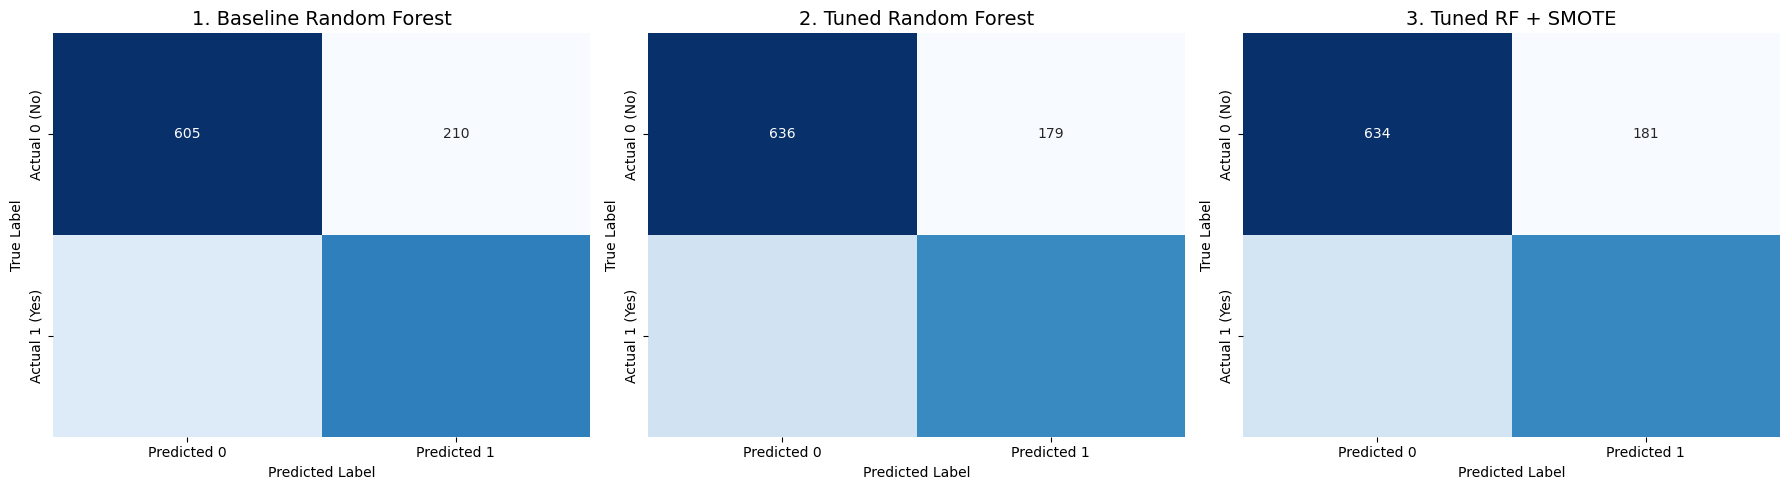

In [282]:
#menampilkan confusion matrix
cm_data = [cm_benchmark_rf, cm_tuning_rf, cm_resampling]
titles = ['1. Baseline Random Forest', '2. Tuned Random Forest', '3. Tuned RF + SMOTE']

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, ax in enumerate(axes):
    sns.heatmap(cm_data[i], annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0 (No)', 'Actual 1 (Yes)'],
                ax=ax)
    ax.set_title(titles[i], fontsize=14)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.tight_layout()
plt.show()

In [276]:
FP = 75000
FN = 150000

without_ml = (FP * (815 + 746)) - FP * 746
benchmark_rf = 210 * FP + FN * 261
tuning_rf = 179 * FP + FN * 268
resampling = 181 * FP + FN * 264


print(f"""
Total kerugian tanpa machine learning {without_ml}
Total kerugian dengan machine learning benchmark {benchmark_rf}
Total kerugian dengan machine learning yg dituning {tuning_rf}
Total kerugian dengan machine learning yg diresampling {resampling}

Dengan benchmark machine learning kita bisa mengurangi kerugian sebesar {without_ml - benchmark_rf}
atau sebesar {((without_ml - benchmark_rf) / without_ml) * 100:.2f}%
Dengan machine learning yg di tuning kita bisa mengurangi kerugian sebesar {without_ml - tuning_rf}
atau sebesar {((without_ml - tuning_rf) / without_ml) * 100:.2f}%
Dengan machine learning yg di resampling kita bisa mengurangi kerugian sebesar {without_ml - resampling}
atau sebesar {((without_ml - resampling) / without_ml) * 100:.2f}%""")


Total kerugian tanpa machine learning 61125000
Total kerugian dengan machine learning 54900000
Total kerugian dengan machine learning 53625000
Total kerugian dengan machine learning 53175000

Dengan benchmark machine learning kita bisa mengurangi kerugian sebesar 6225000
atau sebesar 10.18%
Dengan machine learning yg di tuning kita bisa mengurangi kerugian sebesar 7500000
atau sebesar 12.27%
Dengan machine learning yg di resampling kita bisa mengurangi kerugian sebesar 7950000
atau sebesar 13.01%


Kesimpulan:

- Dengan menggunakan model Random Forest benchmark, kita berhasil mengurangi kerugian hingga sekitar 10,18%.
- Dengan melakukan tuning parameter, pengurangan kerugian meningkat menjadi 12,27%.
- Terakhir, teknik resampling yang ditambahkan pada tuning memberikan hasil terbaik, mengurangi kerugian hingga 13,01%.

Ini menandakan bahwa optimasi model melalui tuning dan resampling sangat memberikan nilai tambah nyata bagi bisnis, dengan mengurangi kerugian finansial secara signifikan.

Pada tahap awal eksplorasi, model tuning tanpa resampling menunjukkan performa yang paling bagus sehingga saya memutuskan untuk memilih model tuning tanpa resampling akan tetapi pengerjaan machine learning tidak hanya dikerjakan sehari, sehingga Machine learning ini beberapa kali di jalankan (run) ulang dan akhirnya menunjukkan hasil pada model resampling yang berbeda dimana saat ini model resampling menunjukkan nilai yang lebih besar.

Akan tetapi saya tetap memutuskan untuk menggunakan model tuning tanpa resampling karena:
- Lebih simpel: Kode lebih clean, pipeline lebih mudah dipahami dan dipertahankan.
- Stabil: Model tuning biasa biasanya lebih stabil tanpa variasi besar akibat teknik resampling yang kadang bikin model overfit ke data minoritas.

## Analisis Threshold

mengevaluasi performa model di berbagai nilai threshold probabilitas untuk memilih yang paling sesuai dengan kebutuhan bisnis dan trade-off metrik klasifikasi

In [222]:
from sklearn.metrics import precision_recall_fscore_support

# Prediksi probabilitas kelas positif dari RF tuning
y_proba_rf = rf_tuning.predict_proba(X_test)[:, 1]

# Fungsi evaluasi threshold
def evaluate_threshold_rf(threshold):
    y_pred_custom = (y_proba_rf >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_custom, average='binary')
    print(f'Threshold: {threshold:.2f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}')
    return precision, recall, f1

# Fungsi hitung kerugian berdasarkan confusion matrix
def calculate_loss_rf(threshold, fp_cost=75000, fn_cost=150000):
    y_pred_custom = (y_proba_rf >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_custom).ravel()
    total_loss = fp * fp_cost + fn * fn_cost
    print(f'Threshold: {threshold:.2f} | FP: {fp} | FN: {fn} | Total Loss: Rp{total_loss:,}')
    return total_loss

# Coba berbagai threshold
thresholds = np.arange(0.1, 1.0, 0.05)

for t in thresholds:
    evaluate_threshold_rf(t)
    calculate_loss_rf(t)


Threshold: 0.10 | Precision: 0.487 | Recall: 0.993 | F1: 0.653
Threshold: 0.10 | FP: 781 | FN: 5 | Total Loss: Rp59,325,000
Threshold: 0.15 | Precision: 0.499 | Recall: 0.972 | F1: 0.659
Threshold: 0.15 | FP: 729 | FN: 21 | Total Loss: Rp57,825,000
Threshold: 0.20 | Precision: 0.521 | Recall: 0.936 | F1: 0.669
Threshold: 0.20 | FP: 642 | FN: 48 | Total Loss: Rp55,350,000
Threshold: 0.25 | Precision: 0.541 | Recall: 0.885 | F1: 0.671
Threshold: 0.25 | FP: 561 | FN: 86 | Total Loss: Rp54,975,000
Threshold: 0.30 | Precision: 0.574 | Recall: 0.846 | F1: 0.684
Threshold: 0.30 | FP: 469 | FN: 115 | Total Loss: Rp52,425,000
Threshold: 0.35 | Precision: 0.605 | Recall: 0.790 | F1: 0.685
Threshold: 0.35 | FP: 385 | FN: 157 | Total Loss: Rp52,425,000
Threshold: 0.40 | Precision: 0.637 | Recall: 0.732 | F1: 0.681
Threshold: 0.40 | FP: 311 | FN: 200 | Total Loss: Rp53,325,000
Threshold: 0.45 | Precision: 0.685 | Recall: 0.684 | F1: 0.684
Threshold: 0.45 | FP: 235 | FN: 236 | Total Loss: Rp53,025,0

In [223]:
y_proba_rf = rf_tuning.predict_proba(X_test)[:, 1]

# Terapkan threshold custom 0.35
threshold = 0.35
y_pred_custom = (y_proba_rf >= threshold).astype(int)

# Buat confusion matrix dengan prediksi threshold custom
cm = confusion_matrix(y_test, y_pred_custom)
print(f"Confusion Matrix with Threshold {threshold}:\n {cm}")

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_custom))

Confusion Matrix with Threshold 0.55:
 [[430 385]
 [157 589]]

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.53      0.61       815
           1       0.60      0.79      0.68       746

    accuracy                           0.65      1561
   macro avg       0.67      0.66      0.65      1561
weighted avg       0.67      0.65      0.65      1561



In [277]:
FP = 75000
FN = 150000

without_ml = (FP * (815 + 746)) - FP * 746
fr_th = 385 * FP + FN * 157

print(f"""
Total kerugian tanpa machine learning {without_ml}
Total kerugian dengan machine learning {fr_th}
Dengan machine learning algorithma Random Forest Threshold 0.35 kita bisa mengurangi kerugian sebesar {without_ml - fr_th}
atau sebesar {((without_ml - fr_th) / without_ml) * 100:.2f}%""")


Total kerugian tanpa machine learning 61125000
Total kerugian dengan machine learning 52425000
Dengan machine learning algorithma Random Forest Threshold 0.35 kita bisa mengurangi kerugian sebesar 8700000
atau sebesar 14.23%


Dari hasil evaluasi threshold bisa kita lihat bahwa threshold 0.35 bisa menekan kerugian dari yang sebelumnya sebesar Rp 7.500.000 atau sebesar 12.27% menjadi Rp 8.700.000 atau sebesar 14.23%. Pengurangan ini menunjukkan efektivitas model dalam memprediksi nasabah yang berpotensi untuk deposit, sehingga langkah preventif dapat diambil lebih tepat sasaran dan mengurangi biaya kerugian.

In [225]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, scoring=f2_score, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
    )

    # Mean dan std
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Train score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="CV score")
    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.title("Learning Curve")
    plt.xlabel("Training Size")
    plt.ylabel(scoring)
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


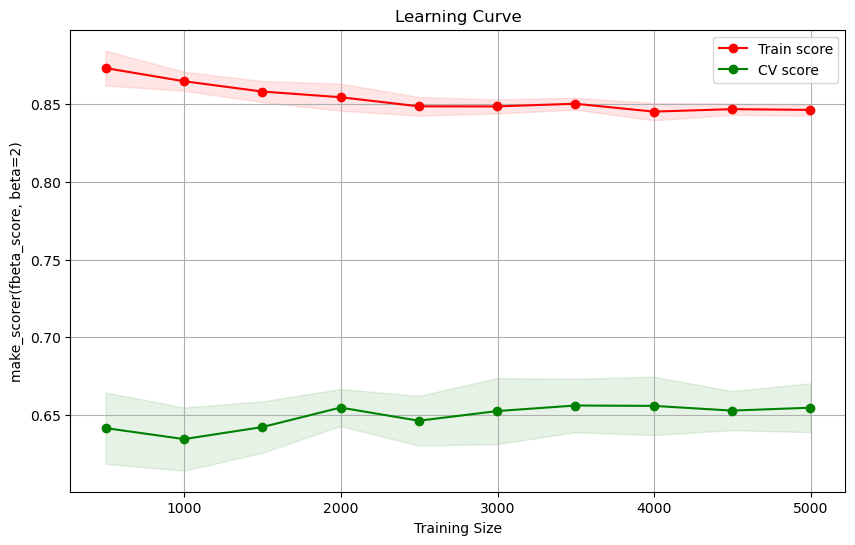

In [226]:
plot_learning_curve(rf_tuning_smote, X_train, y_train, scoring=f2_score)

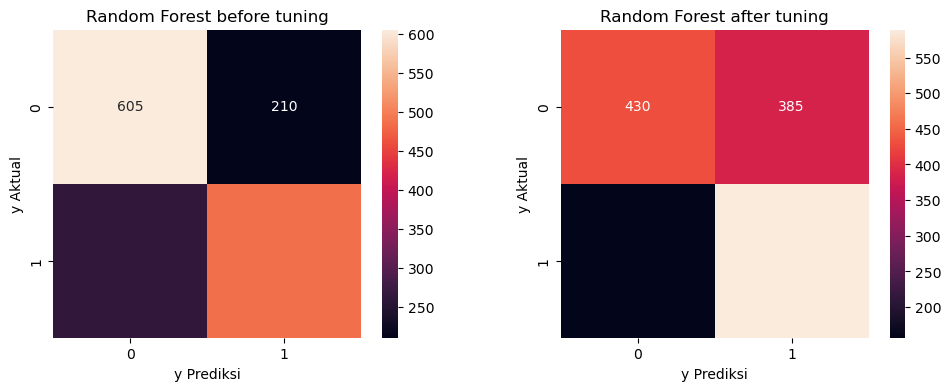

In [227]:
plt.figure(figsize=(12,4))

# Model Random Forest before tuning
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='.0f', square=True)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual')
plt.title('Random Forest before tuning')

# Model Random Forest after tuning
plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, y_pred_custom), annot=True, fmt='.0f', square=True)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual')
plt.title('Random Forest after tuning');

## Feature Importance

In [228]:
rf_tuning['model'].feature_importances_

array([0.14977603, 0.16925284, 0.04975961, 0.0196974 , 0.00881281,
       0.0069932 , 0.01859439, 0.00762858, 0.00903318, 0.01273062,
       0.00644215, 0.01708623, 0.00893434, 0.00277807, 0.01337149,
       0.05192574, 0.01633687, 0.0028965 , 0.01085139, 0.00931154,
       0.01625274, 0.01682105, 0.01380226, 0.0194918 , 0.01468743,
       0.01320411, 0.00820364, 0.00451427, 0.03779233, 0.00877447,
       0.0126934 , 0.01371648, 0.0143913 , 0.00157397, 0.01104716,
       0.00358572, 0.01245819, 0.01004768, 0.01237601, 0.0101349 ,
       0.01476699, 0.0010201 , 0.0383072 , 0.02194949, 0.05325749,
       0.00672283, 0.01619397])

In [229]:
# mengambil nama fitur dari transformer
try:
    feature_names = rf_tuning.named_steps['transformer'].get_feature_names_out()
except:
    feature_names = rf_tuning['transformer'].get_feature_names_out()


# mengambil skor berdasarkan fitur-fitur di model
try:
    scores = rf_tuning.named_steps['model'].feature_importances_
except:
    scores = rf_tuning['model'].feature_importances_


# membuat DataFrame
feature_importance_df = pd.DataFrame({
    'Fitur': feature_names,
    'Skor': scores
})

# mengurutkan berdasarkan skor tertinggi
sorted_feature_importance = feature_importance_df.sort_values(by='Skor', ascending=False)

print("Peringkat Kepentingan Fitur Model Random Forest:")
sorted_feature_importance

Peringkat Kepentingan Fitur Model Random Forest:


,Fitur,Skor
1,scaling__balance,0.169253
0,scaling__age,0.149776
44,remainder__pdays,0.053257
15,onehot__contact_unknown,0.051926
2,scaling__campaign,0.049760
42,remainder__housing,0.038307
28,onehot__poutcome_success,0.037792
43,remainder__loan,0.021949
3,onehot__job_blue-collar,0.019697
23,onehot__month_may,0.019492


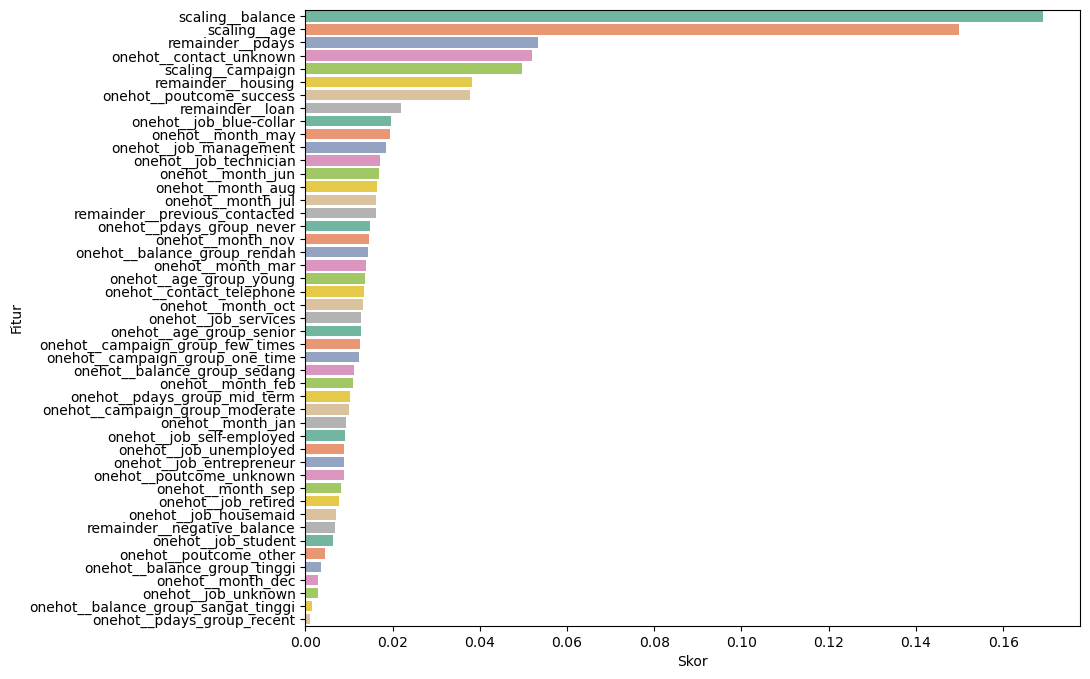

In [230]:
plt.figure(figsize=(10, 8))
sns.barplot(data=sorted_feature_importance, y='Fitur', x='Skor', palette='Set2');

Berdasarkan skoring fitur dari model Random Forest dapat kita lihat bahwa:
- Balance memiliki skor paling tinggi yaitu 0.169253, ini menandakan jumlah balance nasabah mempengaruhi keputusan untuk deposito, dimana ini merupakan hal yang wajar dikarenakan untuk melakukan deposito, nasabah memerlukan saldo atau uang.
- Age juga memiliki nilai skor yang cukup tinggi yaitu 0.149776, umur juga memiliki peranan yang penting dalam keputusan deposito

Kolom-kolom yang dibuat dalam penanganan outlier seperti kolom pdays_group, campaign_group, balance_group, dan age_group juga menunjukkan nilai importance, menandakan bahwa proses feature engineering yang dilakukan sebelumnya berhasil menambahkan informasi yang relevan ke dalam model.

## Conclusion & Recommendation

In [281]:
print(f"Confusion Matrix with Threshold {threshold}:\n {cm}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_custom))


print(f"""\n
Total kerugian tanpa machine learning {without_ml}
Total kerugian dengan machine learning {fr_th}
Dengan machine learning algorithma Random Forest Threshold 0.35 kita bisa mengurangi kerugian sebesar {without_ml - fr_th}
atau sebesar {((without_ml - fr_th) / without_ml) * 100:.2f}%""")

Confusion Matrix with Threshold 0.35:
 [[430 385]
 [157 589]]

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.53      0.61       815
           1       0.60      0.79      0.68       746

    accuracy                           0.65      1561
   macro avg       0.67      0.66      0.65      1561
weighted avg       0.67      0.65      0.65      1561



Total kerugian tanpa machine learning 61125000
Total kerugian dengan machine learning 52425000
Dengan machine learning algorithma Random Forest Threshold 0.35 kita bisa mengurangi kerugian sebesar 8700000
atau sebesar 14.23%


Tujuan dari project ini adalah membuat model machine learning yang mampu menangkap sebanyak mungkin nasabah yang akan deposito dan sesuai dengan prioritas bisnis: **lebih baik menghubungi beberapa orang yang salah, daripada melewatkan orang yang benar-benar akan deposit**
<br>
<br>

- Cost FP: Rp 75.000
- Cost FN: Rp 150.000

Machine learning membantu kita dalam:
1. Mengenali **79%** dari nasabah yang benar-benar akan melakukan deposito

Berdasarkan hasil Classification Report dari model kita, kita bisa simpulkan bahwa seandainya nanti kita menggunakan model kita untuk memprediksi apakah nasabah tersebut akan deposit atau tidak, model ini mampu mengenali **79%** dari nasabah yang benar-benar akan melakukan deposito, ini menunjukkan kemampuan machine learning untuk mengenali nasabah potensial sehingga promosi atau marketing bisa diarahkan ke target yang lebih relevan.

2. Efisiensi Promosi

    Sebelum mengunakan machine learning, tim marketing akan menghubungi seluruh nasabah karena tidak ingin melewatkan nasabah potensial, jadi biaya yang dikeluarkan untuk promosi adalah:
    - Pengeluaran perusahaan untuk promosi (TP+FP+TN+FN): Rp 75.000 x 1556 = Rp 116.700.000
    - Promosi yang tepat sasaran pada orang yang deposito (TP+FN): Rp 75.000 x 746 = Rp 55.950.000
    - Artinya perusahaan mengeluarkan biaya promosi sia-sia sebesar: Rp 116.700.000 - Rp 55.950000 = Rp 60.750.000

    Dengan Machine learning, model memprediksi nasabah yang akan deposit sebanyak 385 + 589 = 974 
    - Pengeluaran perusahaan untuk promosi berdasarkan prediksi ML: Rp 75.000 x 974 = Rp 73.050.000
    - Promosi yang tepat sasaran pada orang yang deposito (TP+FN): Rp 75.000 x 589 = Rp 44.175.000
    - Artinya perusahaan mengeluarkan biaya promosi sia-sia berdasarkan prediksi ML sebesar: Rp 73.050.000 - Rp 44.175.000 = Rp 28.875.000

        Machine learning mampu **menekan biaya promosi sebanyak 52,47%**

3. Akurasi Targeting yang Lebih Tinggi
Dari 974 nasabah yang diprediksi akan deposit oleh ML, sebanyak 589 nasabah benar-benar deposit artinya **60,47% promosi tepat sasaran** dibandingkan tanpa ML hanya sebanyak **47,79%** promosi tepat sasaran.

4. Penurunan kerugian sebesar **14.23%**

    **Tanpa menggunakan ML**

    Sebelum menggunakan ML, perusahaan tidak mengetahui siapa saja nasabah yg akan deposito, sehingga harus mengeluarkan cost untuk promosi ke semua nasabah. Perusahaan tidak mau ambil resiko karena cost kehilangan nasabah lebih besar.

    Kita asumsikan ketika seorang nasabah diberikan promosi, maka nasabah tersebut tidak akan deposito.
    - Pengeluaran perusahaan untuk promosi (TP+FP+TN+FN): Rp 75.000 x 1556 = Rp 116.700.000
    - Promosi yang tepat sasaran pada orang yang deposito (TP+FN): Rp 75.000 x 746 = Rp 55.950.000
    - Artinya perusahaan mengeluarkan biaya promosi sia-sia sebesar: Rp 116.700.000 - Rp 55.950000 = Rp 60.750.000

    **Dengan menggunakan ML**

    Setelah menggunakan ML, perusahaan jadi bisa memprediksi siapa saja nasabah yg akan deposito, sehingga bisa mengeluarkan cost untuk promosi lebih tepat sasaran.
    - Pengeluaran perusahaan untuk salah promosi ke nasabah loyal (FP): Rp 75.000 x 385 = Rp 28.875.000
    - Perusahaan kehilangan nasabah karena tidak terprediksi akan deposito (FN): Rp 150.000 x 157 = Rp 23.550.000
    - Artinya perusahaan mengalami kerugian: Rp 28.875.000 + Rp 23.550.000 = Rp 52.425.000

    **Kerugian menurun setelah pakai ML**

    - Kerugian sebelum pakai ML: Rp 60.750.000
    - Kerugian setelah pakai ML:  Rp 52.425.000
    - ML berhasil menurunkan kerugian perusahaan sebesar **Rp 8.700.000 atau sebesar 14.23%.**


Berdasarkan perhitungan di atas, maka perusahaan tersebut akan menghemat biaya yang cukup besar tanpa mengorbankan terlalu banyak jumlah potensial nasabah.

## Rekomendasi

Machine learning yang sekarang sudah cukup bagus karena sudah bisa mendeteksi 79% nasabah yang akan deposit, akan tetapi ada beberapa hal yang bisa dilakukan oleh perusahaan, seperti:

- Melengkapi data pada kolom contact untuk memudahkan ML mempelajari data, untuk saat ini masih ada contact yg unknown.
- Gunakan hasil prediksi machine learning untuk mengidentifikasi nasabah yang kemungkinan besar menerima tawaran deposito untuk menghemat biaya marketing
- Gunakan A/B testing untuk membandingkan efektivitas channel terhadap kelompok nasabah yang dipilih model sehingga nantinya kita bisa mengukur akurasi model dalam memprediksi data


Jangan gunakan machine learning apabila:
- Adanya perubahan perilaku nasabah yang ekstrim akibat faktor eksternal seperti krisis atau pandemi
- Data nasabah tidak lengkap atau banyak missing value
- Profil nasabah baru tidak berkaitan dengan fitur yang digunakan untuk melatih model

# Menyimpan model terbaik ke Pickle

In [231]:
import pickle

In [232]:
# best model
rf_tuning = random_rf.best_estimator_
rf_tuning

# fitting
rf_tuning.fit(X_train, y_train)

# save with pickle
pickle.dump(rf_tuning, open('model_randomforest_v1.sav', 'wb'))

In [233]:
# load model

model_loaded = pickle.load(open('model_randomforest_v1.sav', 'rb'))
model_loaded

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', RobustScaler(),
                                                  ['age', 'balance',
                                                   'campaign']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['job', 'contact', 'month',
                                                   'poutcome', 'age_group',
                                                   'balance_group',
                                                   'campaign_group',
                                                   'pdays_group'])])),
                ('model',
                 RandomForestClassifier(min_samples_split=5, n_estimators=200,
                                        random_state=0))])

In [234]:
# y actual = 1 --> deposit
y[0]

1

In [235]:
# customer index 0 akan diprediksi
X.iloc[[0], :]

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,negative_balance,age_group,balance_group,campaign_group,pdays_group,previous_contacted
0,55,admin.,1662,0,0,cellular,jun,2,0,unknown,0,adult,rendah,few_times,never,0


In [237]:
# coba predict pada seorang customer

model_loaded.predict(X.iloc[[0], :])

# customer index 0 diprediksi akan deposit
# prediksinya benar

array([1])

## Coba membuat data nasabah baru

In [238]:
new_customer = pd.DataFrame({
    'age': [35],
    'job': ['services'],
    'balance': [1500],
    'housing': [0],
    'loan': [1],
    'contact': ['cellular'],
    'month': ['nov'],
    'campaign': [1],
    'pdays': [-1],
    'poutcome': ['unknown'],
    'negative_balance': [0],
    'age_group': ['adult'],
    'balance_group': ['rendah'],
    'campaign_group': ['few_times'],
    'pdays_group': ['never'],
    'previous_contacted': [0]
})

new_customer

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,negative_balance,age_group,balance_group,campaign_group,pdays_group,previous_contacted
0,35,services,1500,0,1,cellular,nov,1,-1,unknown,0,adult,rendah,few_times,never,0


In [239]:
# predict pakai pickle
model_loaded.predict(new_customer)

array([0])

Nasabah baru diprediksi masuk ke kelas 0 atau tidak akan melakukan deposito jangka panjang.

## Membuat model Shap

In [240]:
import shap 

In [241]:
rf_tuning

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', RobustScaler(),
                                                  ['age', 'balance',
                                                   'campaign']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['job', 'contact', 'month',
                                                   'poutcome', 'age_group',
                                                   'balance_group',
                                                   'campaign_group',
                                                   'pdays_group'])])),
                ('model',
                 RandomForestClassifier(min_samples_split=5, n_estimators=200,
                                        random_state=0))])

In [ ]:
# mentransform data dari model terbaik di pipeline
X_test_trans = rf_tuning.named_steps['transformer'].transform(X_test)


In [ ]:
# mengubah data dari sparse matrix ke array jika belum
if hasattr(X_test_trans, 'toarray'):
    X_test_trans = X_test_trans.toarray()



In [ ]:
def get_feature_names(column_transformer):
    feature_names = []

    for name, transformer, columns in column_transformer.transformers_:
        if transformer == 'passthrough':
            if isinstance(columns, slice):
                feature_names.extend(X_train.columns[columns].tolist())
            else:
                feature_names.extend(list(columns))
        elif hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(columns)
            feature_names.extend(names.tolist())
        else:
            feature_names.extend(list(columns))
    return feature_names

feature_names = get_feature_names(rf_tuning.named_steps['transformer'])



Fungsi ini digunakan untuk mendapatkan nama kolom asli setelah melewati tahap preprocessing karena seperti yang kita ketahui dalam tahap scaling dan encoding, nama kolom dan strukturnya bisa berubah dari yang sebenarnya.

In [270]:
print(f"Jumlah fitur hasil transform: {len(feature_names)}")
print(f"Shape X_test_trans: {X_test_trans.shape}")


Jumlah fitur hasil transform: 47
Shape X_test_trans: (1561, 47)


In [271]:
print(type(shap_values))
if isinstance(shap_values, list):
    for i, sv in enumerate(shap_values):
        print(f"Class {i} shape: {sv.shape}")
else:
    print(f"shap_values shape: {shap_values.shape}")


<class 'numpy.ndarray'>
shap_values shape: (1561, 47, 2)


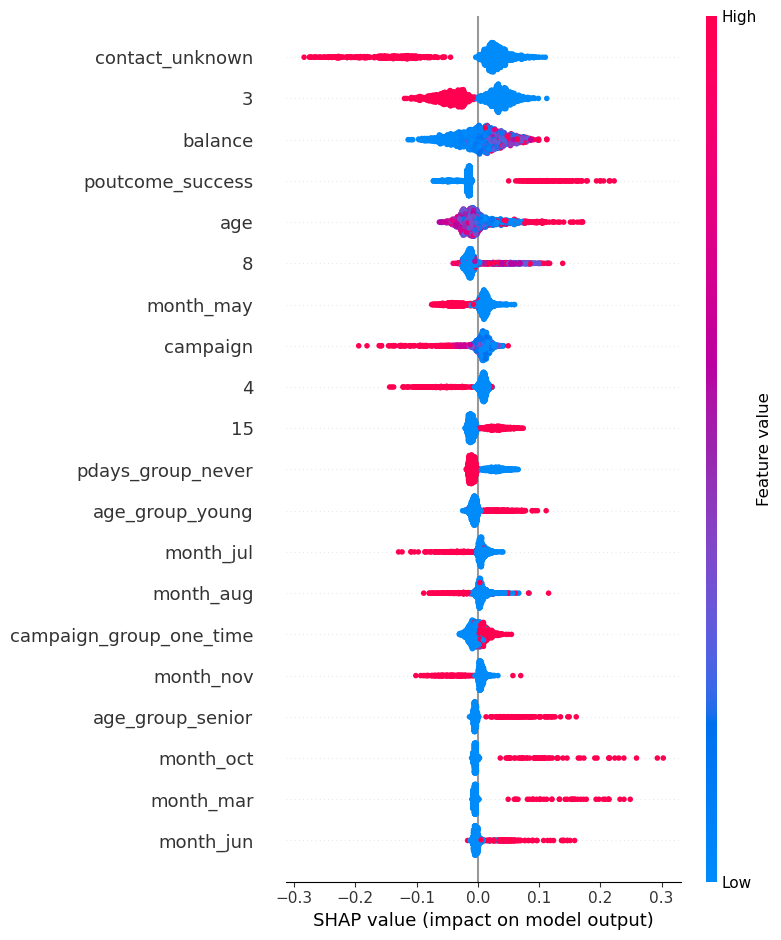

In [272]:
explainer = shap.TreeExplainer(rf_tuning.named_steps['model'])
shap_values = explainer.shap_values(X_test_trans)

feature_names = get_feature_names(rf_tuning.named_steps['transformer'])

shap.summary_plot(shap_values[:, :, 1], X_test_trans, feature_names=feature_names)


In [ ]:
# Membuat fungsi untuk menampilkan plot SHAP untuk 1 index
def shap_plot(index, model, dataframe):
    X_trans = model.named_steps['transformer'].transform(dataframe)
    if hasattr(X_trans, "toarray"):
        X_trans = X_trans.toarray()

    explainer = shap.TreeExplainer(model.named_steps['model'])

    shap_values = explainer.shap_values(X_trans)

    shap.force_plot(
        explainer.expected_value[1],
        shap_values[index][:, 1], 
        X_trans[index],
        feature_names=get_feature_names(model.named_steps['transformer']),
        matplotlib=True
    )
    plt.show()


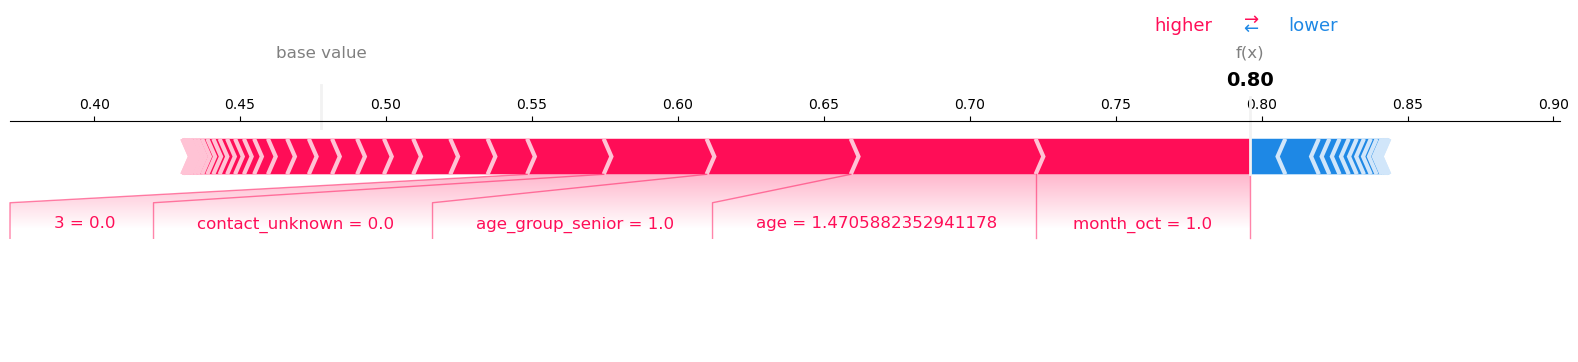

In [274]:
# Menampilkan plot SHAP untuk index 0
print(f"Model seharusnya memprediksi nasabah ini: {('Deposit' if y_test.iloc[0] == 1 else 'Tidak Deposit')}")
shap_plot(0, rf_tuning, X_test)


## Membuat Model LIME

In [253]:
import lime
from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer

In [278]:
# mengambil kolom numerik dan kategorikal
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features = [X_train.columns.get_loc(col) for col in categorical_cols]

# mentransform data
transformer = rf_tuning.named_steps['transformer']
model = rf_tuning.named_steps['model']

X_train_enc = transformer.transform(X_train)
X_test_enc = transformer.transform(X_test)

# mengubah sparse matrix ke array jika diperlukan
if hasattr(X_train_enc, "toarray"):
    X_train_enc = X_train_enc.toarray()
    X_test_enc = X_test_enc.toarray()

# membuat explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_enc,
    feature_names=transformer.get_feature_names_out(X_train.columns),
    class_names=['no', 'yes'],  # ganti sesuai target
    mode='classification',
    verbose=True,
    random_state=42
)

# mengambil satu baris dari data
i = 5
data_row_original = X_test.iloc[i:i+1]

# mengubah baris data ke bentuk yang sesuai untuk LIME
data_row_enc = transformer.transform(data_row_original)
if hasattr(data_row_enc, "toarray"):
    data_row_enc = data_row_enc.toarray()

# membuat fungsi prediksi
def predict_fn_lime(x):
    return model.predict_proba(x)

# penjelasan LIME
exp = explainer.explain_instance(
    data_row=data_row_enc[0],
    predict_fn=predict_fn_lime,
    num_features=10
)



Intercept 0.8165110018221571
Prediction_local [0.50241382]
Right: 0.47518650793650813


In [279]:
# menampilkan hasil LIME
exp.show_in_notebook(show_table=True)

# Print hasil prediksi
print("\nFitur yang mempengaruhi prediksi:")
for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.4f}")



Fitur yang mempengaruhi prediksi:
onehot__month_mar <= 0.00: -0.1703
onehot__month_oct <= 0.00: -0.1377
onehot__contact_unknown <= 0.00: 0.1095
onehot__poutcome_success <= 0.00: -0.1001
onehot__month_sep <= 0.00: -0.0983
onehot__month_jun <= 0.00: -0.0886
remainder__loan <= 0.00: 0.0859
onehot__month_jan <= 0.00: 0.0770
remainder__housing <= 0.00: 0.0622
onehot__contact_telephone > 0.00: -0.0536


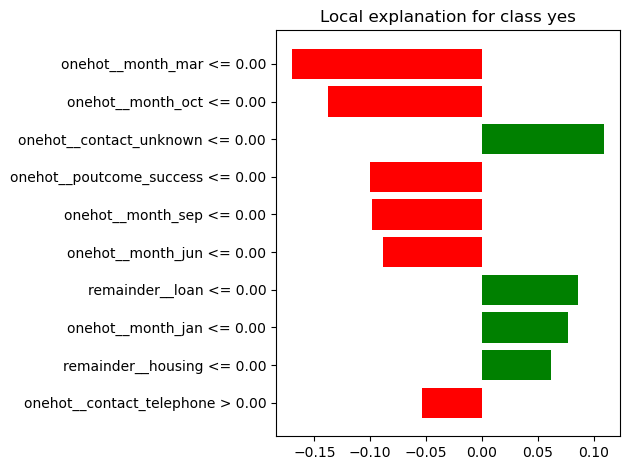

In [280]:
# menampilkan plot LIME
fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()